

# **Assignment - step 1** (Group 16)

# **Introduction**

This assignment applies different machine learning methods to a music–track dataset to **analyze**, **model**, and **interpret** results for both **regression** and **classification** tasks.

Each row of the dataset represents one track with rich audio/metadata features (e.g., **tempo**, **energy**, **movement**, **loudness**, **mood**, **duration** transforms, circular **key** encodings, etc.).  


Two targets are provided:
- **`target_class`** — a *categorical* label (3 music classes for our group) → **classification**.  
- **`target_regression`** — a *continuous* popularity/impact score → **regression**.  



---

## **Analysis Plan**

### 1) Exploratory Data Analysis (EDA)
- **Descriptive Statistics:** duplicates/constant columns; for numerics: mean/median, std, p5–p95, IQR, min/max, **skewness**/**kurtosis**; for categoricals: **cardinality**, dominant and rare levels.  
- **Data types and missing values:** size and dtypes; missing values;
- **Univariate Analysis:** distributions of individual features  
  - Numeric → histograms/boxplots, outliers, zero inflation, need for transforms (e.g., `log1p`, Yeo–Johnson).  
  - Categorical → frequency bars (top-k), rare-level grouping, consistency of labels.  
- **Bivariate Analysis:** relationships  
  - Feature ↔ **`target_regression`** → Pearson/Spearman, scatter with trend.  
  - Feature ↔ **`target_class`** → box by class, χ².  


---

## **Modeling Tasks**

### 2) Regression — predict `target_regression`
- **Simple Linear Regression:** fit several single-feature models, compare, and **select the best feature**.
- **Multiple Linear Regression:** build models with **selected feature sets** (e.g., SelectKBest/Lasso or EDA-driven subsets).
- **Evaluation (hold-out):** report **R²**, **MAE**, **RMSE**; compare and discuss results.

### 3) Classification — predict `target_class`
- **Methods:** **Logistic Regression**, **LDA**, **QDA** (with appropriate preprocessing and class-imbalance handling).
- **Resampling (required):** **Holdout**, **k-fold CV (k=5, k=10)**, **LOOCV**, **Bootstrap**.  
- **Metrics (imbalanced setting):** emphasize **macro-F1** and **balanced accuracy**; include accuracy and (if probabilities used) ROC-AUC (OvR).  

---

> **Summary:** We will start with  rigorous EDA to understand the data and guide preprocessing, then build and evaluate regression and classification models using multiple resampling strategies, reporting both performance and variability to justify the final methodological choices.


In [215]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

import seaborn as sns
import math
from statistics import mean

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import load_digits, load_breast_cancer

df = pd.read_csv('group_16.csv', sep=";")

#Information about dataset dimension
print("Dimension (lines, columns):", df.shape)


Dimension (lines, columns): (3000, 49)


#**Analysis Plan**

## *1.1 - Descriptive statistics*

---
### Descriptive Statistics

Descriptive statistics are the first, essential pass over a dataset to understand **"what we have"** before modeling or drawing conclusions. They summarize data without testing hypotheses.

**What we cover**
- **Central tendency**: mean and median
- **Dispersion**: standard deviation, quartiles, IQR, min and max
- **Distribution shape**: skewness and kurtosis
- **Categorical features**: cardinality and category frequencies

Why this matters for our project
- Exposes data-quality issues like duplicates, outliers, and inconsistent labels  
- Guides cleaning steps such as imputation, type fixes, and category grouping  
- Informs Univariate and Bivariate Analysis and the choice of transformations  
  - High skew in a numeric feature may suggest a log transform  
  - Many rare categories may need consolidation  
  - Large dispersion or extreme values may call for robust methods

By documenting these summaries in our repo with small tables and brief notes, we create a reproducible baseline that justifies preprocessing decisions and ensures every teammate starts from the same, well-understood dataset.

In [216]:
# Preview data
df.head()

duration_1  duration_2  duration_3  duration_4  duration_5  loudness_level  \
0         0.0         0.0         1.0         0.0         0.0             1.0   
1         0.0         1.0         0.0         0.0         0.0             4.0   
2         0.0         0.0         0.0         1.0         0.0             1.0   
3         0.0         0.0         1.0         0.0         0.0             0.0   
4         0.0         0.0         0.0         1.0         0.0             3.0   

   popularity_level  tempo_class  time_signature  key_mode  ...  \
0               3.0          1.0        0.221824  1.583423  ...   
1               1.0          1.0        0.221824  0.485996  ...   
2               3.0          1.0        0.221824  0.457857  ...   
3               2.0          2.0        0.221824 -0.104926  ...   
4               3.0          1.0        0.221824 -0.639569  ...   

   is_instrumental  is_dance_hit  temp_zscore  resonance_factor  timbre_index  \
0              0.0           0.0     0.295391         -0.969300      0.226734   
1              0.0           0.0     0.133407          2.299190      0.104618   
2              0.0           0.0    -1.272778          1.045412      0.287942   
3              0.0           0.0    -1.680339          0.549470      0.626315   
4              0.0           0.0    -0.406384         -0.557971      0.725982   

   echo_constant  distorted_movement  signal_power  target_class  \
0              1           -0.528982         0.905      class_68   
1              1            0.323837         0.661      class_68   
2              1           -1.376039         0.397      class_68   
3              1           -0.050712         0.582      class_68   
4              1           -2.401727         0.801      class_68   

   target_regression  
0           0.841125  
1          -0.414207  
2           0.661792  
3           1.334291  
4           0.706625  

[5 rows x 49 columns]



We now identified **data types** (numeric, categorical) to ensure correct preprocessing
.


In [217]:
# Check data types and missing values
data_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique(),
})

data_info['Non-null Count'] = len(df) - data_info['Missing Values']

data_info

Data Type  Missing Values  Unique Values  \
duration_1                      float64               0              2   
duration_2                      float64               0              2   
duration_3                      float64               0              2   
duration_4                      float64               0              2   
duration_5                      float64               0              2   
loudness_level                  float64               0              5   
popularity_level                float64               0              5   
tempo_class                     float64               0              5   
time_signature                  float64               0              4   
key_mode                        float64               0             24   
artist_song_count               float64               0             66   
album_freq                      float64               0             95   
movement_index                  float64               0            601   
intensity_level                 float64               0           2151   
verbal_density                  float64               0            927   
purity_score                    float64               0           1334   
positivity_index                float64               0            767   
activity_rate                   float64               0           2311   
loudness_intensity              float64               0           2425   
happy_dance                     float64               0           2414   
acoustics_instrumental          float64               0           1190   
artists_avg_popularity          float64               0            371   
tempo_vs_genre                  float64               0           2423   
energy_rank_pct                 float64               0            716   
loud_energy_ratio               float64               0           2429   
mood_pca                        float64               0           2440   
mood_cluster                    float64               0             11   
acoustic_valence_mood_cluster   float64               0             11   
explicit                        float64               0              2   
signal_strength                 float64               0            716   
mode_indicator                  float64               0              2   
focus_factor                     object               0            992   
ambient_level                   float64               0            955   
key_sin                         float64               0             11   
key_cos                         float64               0             11   
duration_log                    float64               0           2307   
duration_log_z                  float64               0           2307   
time_signature_class_boolean    float64               0              2   
loudness_yeo                    float64               0           2151   
is_instrumental                 float64               0              2   
is_dance_hit                    float64               0              2   
temp_zscore                     float64               0           2311   
resonance_factor                float64               0           3000   
timbre_index                    float64               0           3000   
echo_constant                     int64               0              1   
distorted_movement              float64               0            728   
signal_power                    float64               0            716   
target_class                     object               0              3   
target_regression               float64               0             96   

                               Non-null Count  
duration_1                               3000  
duration_2                               3000  
duration_3                               3000  
duration_4                               3000  
duration_5                               3000  
loudness_level                           

Although the column focus_factor was stored as an object type (categoric column), it showed numeric strings as a scientific notation. So it was concluded that treating this as categorical would discard its quantitive meaning. Therefore we parsed the strings to a numeric value (float). As seen, the values were successfully transformed to a numeric type.

In [218]:
col = "focus_factor"

# Clean common string artifacts (spaces, separators, percentages)
s = (df[col].astype(str)
              .str.strip()
              .str.replace("\u00a0", " ", regex=False)     # non-breaking space
              .str.replace(",", ".", regex=False))         # convert decimal comma to dot

# Try converting to numeric (accepts scientific notation with 'e'/'E')
num = pd.to_numeric(s, errors="coerce")

# Check how many conversions failed
fails = num.isna().sum()
total = len(num)
print(f"Converted: {total - fails}/{total}  |  Failed: {fails}")

df[col] = num

Converted: 3000/3000  |  Failed: 0


With the built-in Python function, *describe()* we can obtain a summarized view of the numeric colomuns of the dataset. Because the number of numeric columns exceeds the limit allowed, this presentation is divided in 3 tables, with 15 columns each. On the information below we can verify that all collumns' count is equal to 3000 except one: focus_factor. We can conclude that, besides this column, the other numeric ones have no missing values.

In [219]:


# Generate descriptive statistics of the numerical columns
print("\nNumeric columns:")
# df.describe()
num_cols = df.columns.tolist()
for i in range(0, len(num_cols), 15):
    cols = num_cols[i:i+15]
    print(f"\nCols {i+1}–{i+len(cols)}")
    display(df[cols].describe().T)


Numeric columns:

Cols 1–15


count      mean       std       min       25%       50%  \
duration_1         3000.0  0.037000  0.188793  0.000000  0.000000  0.000000   
duration_2         3000.0  0.149333  0.356476  0.000000  0.000000  0.000000   
duration_3         3000.0  0.340000  0.473788  0.000000  0.000000  0.000000   
duration_4         3000.0  0.468000  0.499058  0.000000  0.000000  0.000000   
duration_5         3000.0  0.005667  0.075076  0.000000  0.000000  0.000000   
loudness_level     3000.0  1.681000  1.338097  0.000000  0.000000  2.000000   
popularity_level   3000.0  1.693000  1.044564  0.000000  1.000000  1.000000   
tempo_class        3000.0  1.019000  0.280473  0.000000  1.000000  1.000000   
time_signature     3000.0  0.086987  0.786029 -6.712656  0.221824  0.221824   
key_mode           3000.0  0.052363  1.011637 -1.511882 -0.920961  0.176466   
artist_song_count  3000.0  0.227381  1.035396 -0.575306 -0.455086 -0.166557   
album_freq         3000.0  0.605123  1.627317 -0.514901 -0.472292 -0.259249   
movement_index     3000.0  0.841537  0.809963 -2.096325  0.374257  0.940402   
intensity_level    3000.0  0.253941  0.616822 -3.391909 -0.047929  0.379961   
verbal_density     3000.0  0.326129  1.129253 -0.580261 -0.411911 -0.145673   

                        75%       max  
duration_1         0.000000  1.000000  
duration_2         0.000000  1.000000  
duration_3         1.000000  1.000000  
duration_4         1.000000  1.000000  
duration_5         0.000000  1.000000  
loudness_level     3.000000  4.000000  
popularity_level   3.000000  4.000000  
tempo_class        1.000000  4.000000  
time_signature     0.221824  2.533318  
key_mode           1.020640  1.611562  
artist_song_count  0.650941  4.257551  
album_freq         1.402485  7.751164  
movement_index     1.414351  2.404024  
intensity_level    0.681193  1.777561  
verbal_density     0.636964  8.250528


Cols 16–30


count      mean       std       min       25%  \
purity_score                   3000.0 -0.160754  0.767656 -0.946983 -0.795534   
positivity_index               3000.0  0.693538  0.847993 -1.688136  0.100031   
activity_rate                  3000.0 -0.008336  0.985786 -2.931658 -0.870607   
loudness_intensity             3000.0  0.057787  0.765294 -3.512291 -0.378797   
happy_dance                    3000.0  0.928830  0.978573 -1.368643  0.172337   
acoustics_instrumental         3000.0 -0.297890  0.096215 -0.306318 -0.306318   
artists_avg_popularity         3000.0 -0.460909  1.036908 -1.740774 -1.260077   
tempo_vs_genre                 3000.0  0.000503  1.028918 -3.051139 -0.866482   
energy_rank_pct                3000.0 -0.013130  0.775490 -1.730016 -0.626553   
loud_energy_ratio              3000.0 -0.007704  0.085176 -0.009501 -0.009393   
mood_pca                       3000.0  0.649943  0.759076 -2.061500  0.142690   
mood_cluster                   3000.0 -0.108453  1.013473 -1.443801 -1.109797   
acoustic_valence_mood_cluster  3000.0  0.134180  0.864999 -1.581244 -0.592590   
explicit                       3000.0  0.088000  0.283342  0.000000  0.000000   
signal_strength                3000.0  0.659147  0.183644  0.000071  0.537000   

                                    50%       75%       max  
purity_score                  -0.452323  0.283721  2.024214  
positivity_index               0.802029  1.385421  2.005455  
activity_rate                 -0.073994  0.654395  3.064775  
loudness_intensity             0.167237  0.591682  2.573548  
happy_dance                    0.993344  1.649884  3.351873  
acoustics_instrumental        -0.306318 -0.306263  3.404507  
artists_avg_popularity        -0.902827  0.483483  3.391653  
tempo_vs_genre                -0.113650  0.660354  3.283672  
energy_rank_pct               -0.011881  0.598034  1.677052  
loud_energy_ratio             -0.009327 -0.009212  4.655974  
mood_pca                       0.780853  1.230058  2.147174  
mood_cluster                  -0.441789  0.894228  1.896240  
acoustic_valence_mood_cluster  0.066512  0.725614  1.714268  
explicit                       0.000000  0.000000  1.000000  
signal_strength                0.682000  0.803000  0.989000


Cols 31–45


count      mean       std       min       25%  \
mode_indicator                3000.0  0.666333  0.471601  0.000000  0.000000   
focus_factor                  3000.0  0.010827  0.067054  0.000000  0.000000   
ambient_level                 3000.0  0.207568  0.192374  0.015000  0.092500   
key_sin                       3000.0 -0.083687  0.674214 -1.000000 -0.866025   
key_cos                       3000.0  0.045203  0.732611 -1.000000 -0.866025   
duration_log                  3000.0  1.420383  0.263816  0.339634  1.302820   
duration_log_z                3000.0 -0.357406  0.910604 -4.087793 -0.763196   
time_signature_class_boolean  3000.0  0.983667  0.126775  0.000000  1.000000   
loudness_yeo                  3000.0  0.205213  0.760864 -2.454420 -0.285878   
is_instrumental               3000.0  0.002000  0.044684  0.000000  0.000000   
is_dance_hit                  3000.0  0.002000  0.044684  0.000000  0.000000   
temp_zscore                   3000.0 -0.008336  0.985782 -2.931645 -0.870603   
resonance_factor              3000.0 -0.011632  0.992020 -3.360448 -0.699904   
timbre_index                  3000.0  0.489889  0.287163  0.000002  0.241753   
echo_constant                 3000.0  1.000000  0.000000  1.000000  1.000000   

                                       50%       75%       max  
mode_indicator                1.000000e+00  1.000000  1.000000  
focus_factor                  1.000000e-06  0.000075  0.954000  
ambient_level                 1.290000e-01  0.260000  0.989000  
key_sin                       0.000000e+00  0.500000  1.000000  
key_cos                      -1.836970e-16  0.866025  1.000000  
duration_log                  1.452051e+00  1.574035  2.388151  
duration_log_z               -2.481004e-01  0.172949  2.983005  
time_signature_class_boolean  1.000000e+00  1.000000  1.000000  
loudness_yeo                  2.398938e-01  0.705554  5.666622  
is_instrumental               0.000000e+00  0.000000  1.000000  
is_dance_hit                  0.000000e+00  0.000000  1.000000  
temp_zscore                  -7.399337e-02  0.654392  3.064761  
resonance_factor             -1.783998e-03  0.663309  3.705243  
timbre_index                  4.852464e-01  0.732659  0.999930  
echo_constant                 1.000000e+00  1.000000  1.000000


Cols 46–49


count      mean       std       min       25%       50%  \
distorted_movement  3000.0  0.010426  1.000689 -3.266071 -0.615416  0.087583   
signal_power        3000.0  0.659147  0.183644  0.000071  0.537000  0.682000   
target_regression   3000.0 -0.412907  1.036746 -1.490205 -1.400539 -0.862540   

                         75%       max  
distorted_movement  0.756009  2.409787  
signal_power        0.803000  0.989000  
target_regression   0.437625  2.903456

Down below we can check the target variables' distribution in a more accurate way.



In [220]:
# Target variables distribution

target_numeric_variable = df['target_regression']
target_categorical_variable = df['target_class']
counts_num = target_numeric_variable.value_counts()
percent_num = target_numeric_variable.value_counts(normalize=True)
percent100_num = target_numeric_variable.value_counts(normalize=True).mul(100).round(2).astype(str)+'%'
counts_cat = target_categorical_variable.value_counts()
percent_cat = target_categorical_variable.value_counts(normalize=True)
percent100_cat = target_categorical_variable.value_counts(normalize=True).mul(100).round(2).astype(str)+'%'
num_table = pd.DataFrame({'Absolute': counts_num,'Percent': percent100_num})
cat_table = pd.DataFrame({'Absolute': counts_cat,'Percent': percent100_cat})

display(num_table)
display(cat_table)

Absolute Percent
target_regression                  
-1.490205               613  20.43%
 0.347959               128   4.27%
-1.131539               119   3.97%
 0.482459               112   3.73%
-1.445372               109   3.63%
...                     ...     ...
 2.858622                 2   0.07%
 2.230956                 2   0.07%
 2.903456                 1   0.03%
 2.768956                 1   0.03%
 2.589623                 1   0.03%

[96 rows x 2 columns]

Absolute Percent
target_class                  
class_68          1000  33.33%
class_89          1000  33.33%
class_90          1000  33.33%

## *2 - Univariate Analysis*

---

Univariate analysis examines one variable at a time to understand its distribution before any modeling. For **numeric** columns (features) we look at histograms and density. For **categorical** features we looak at bar plots.


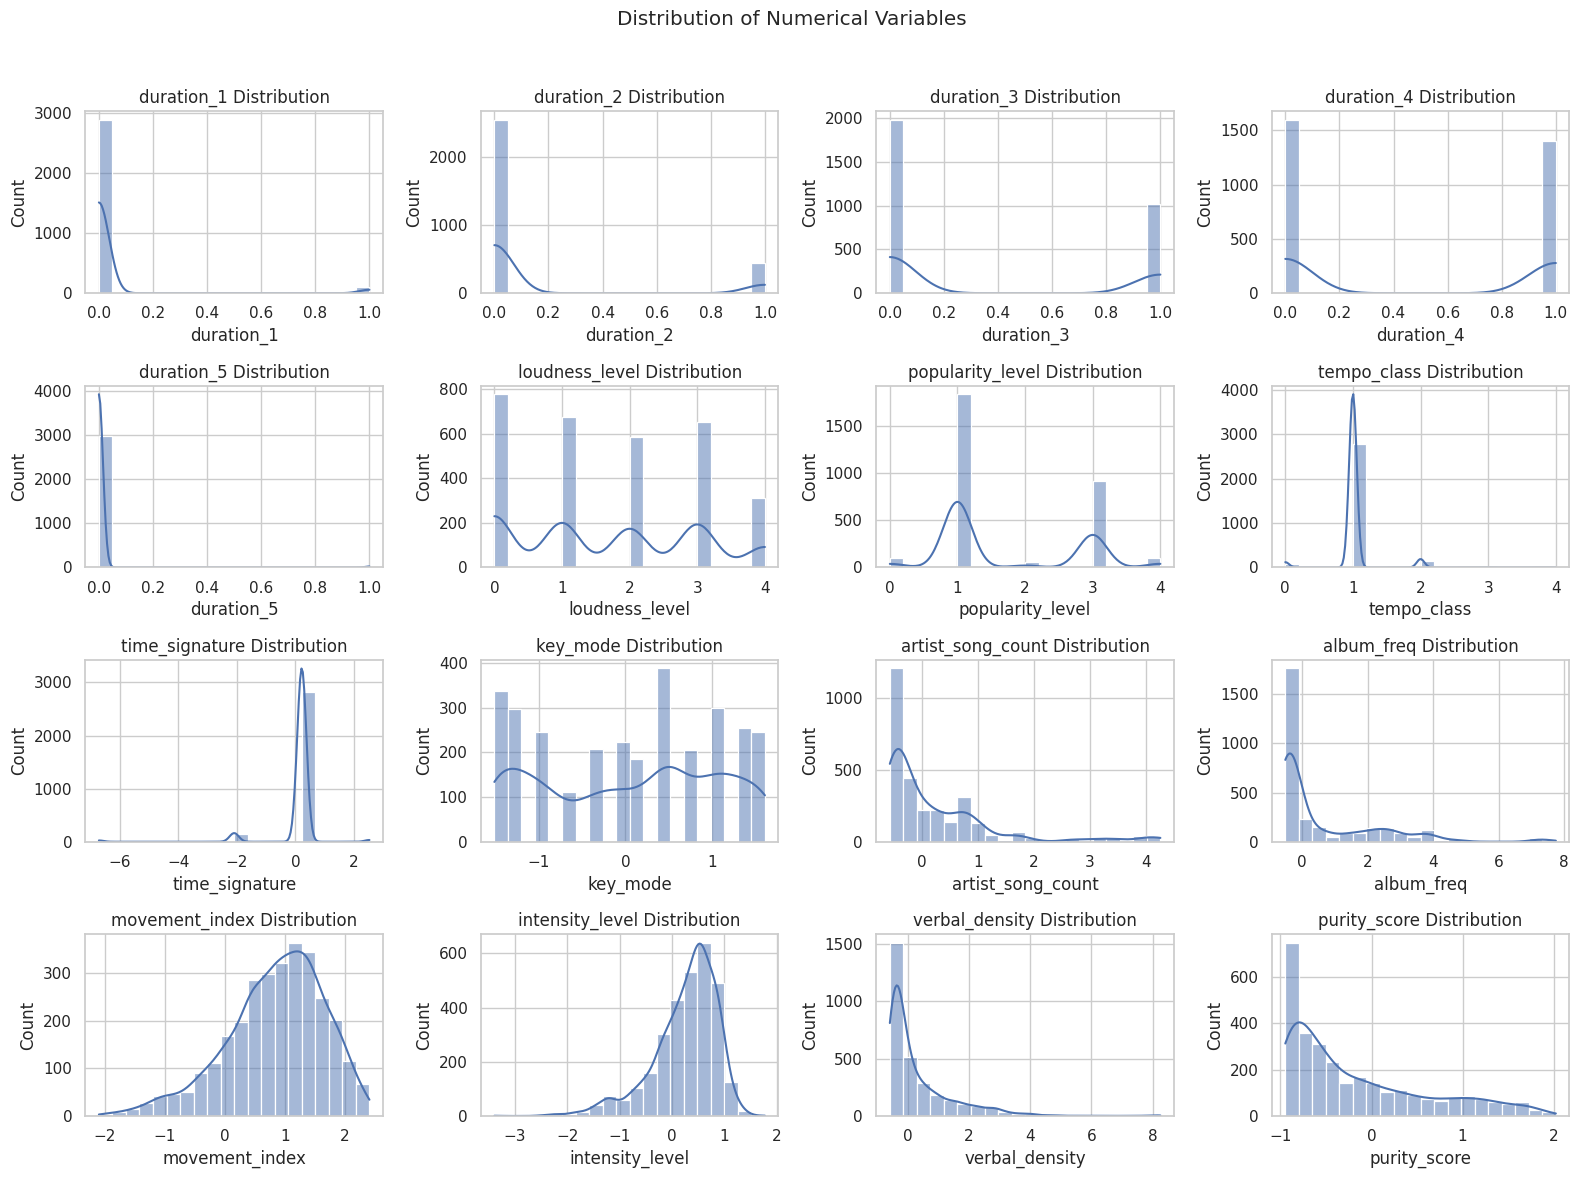

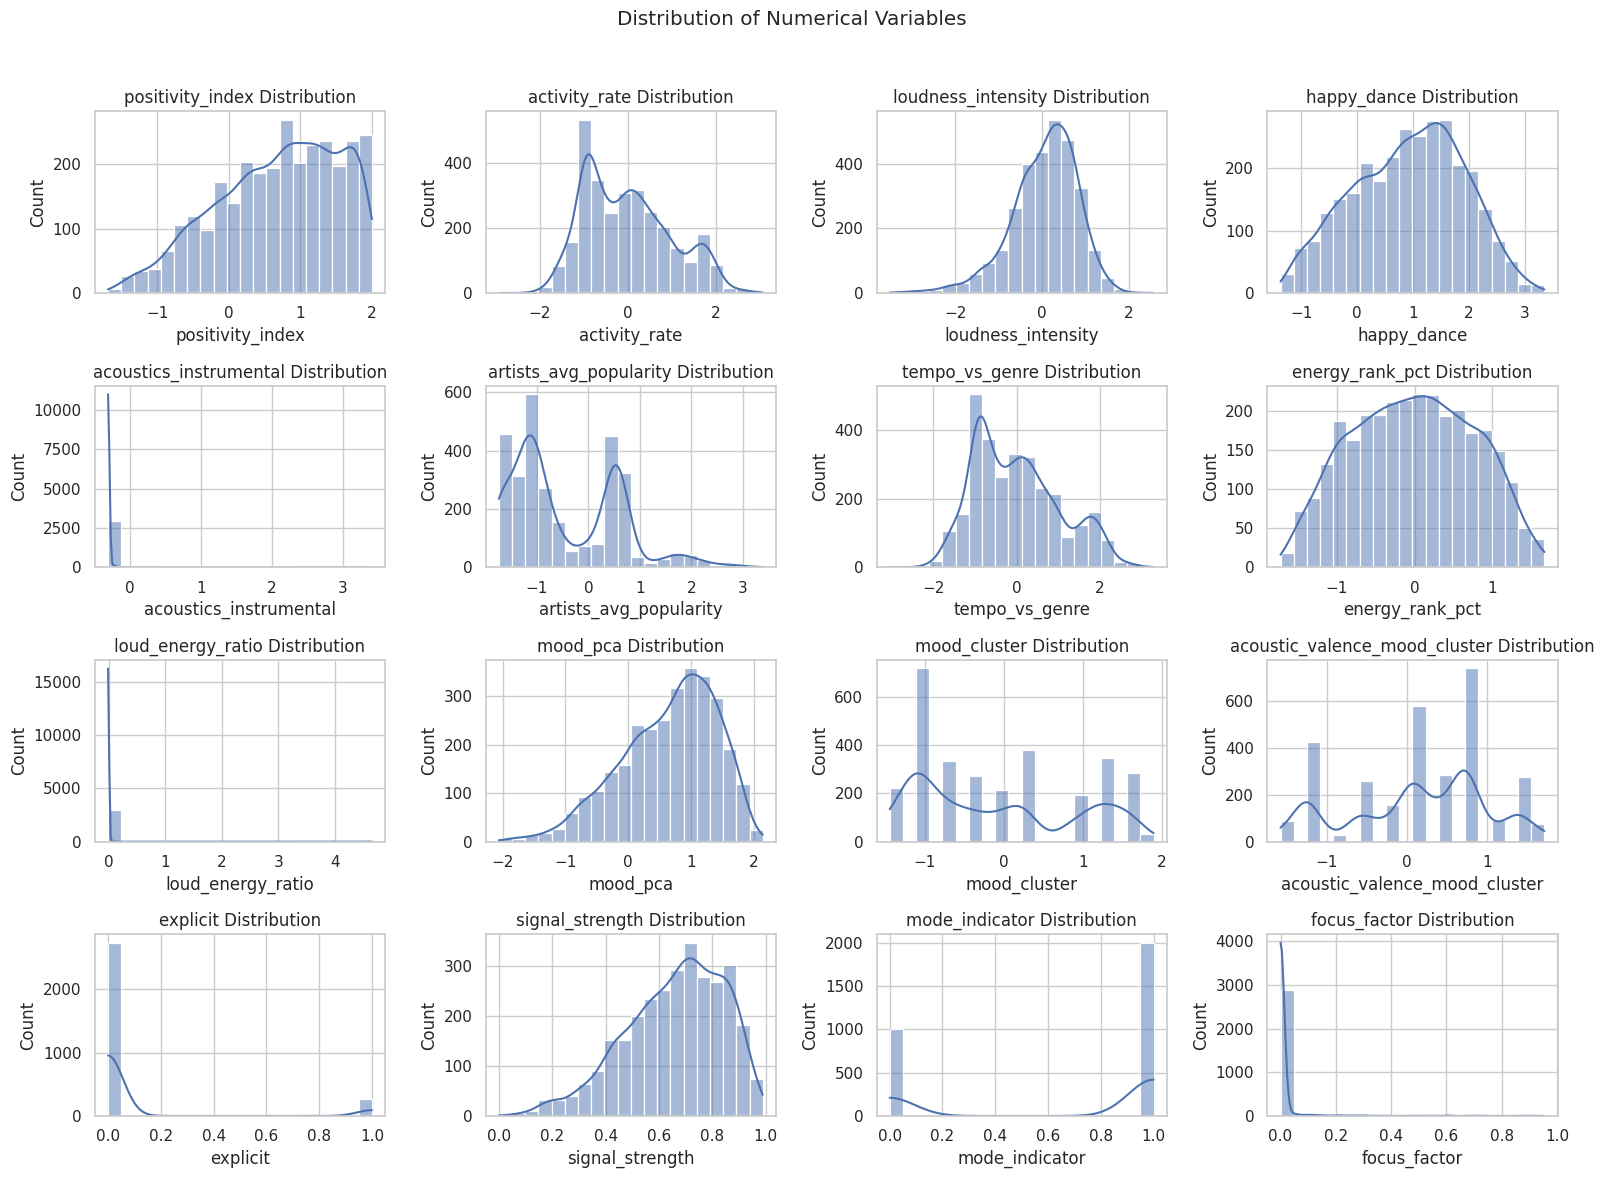

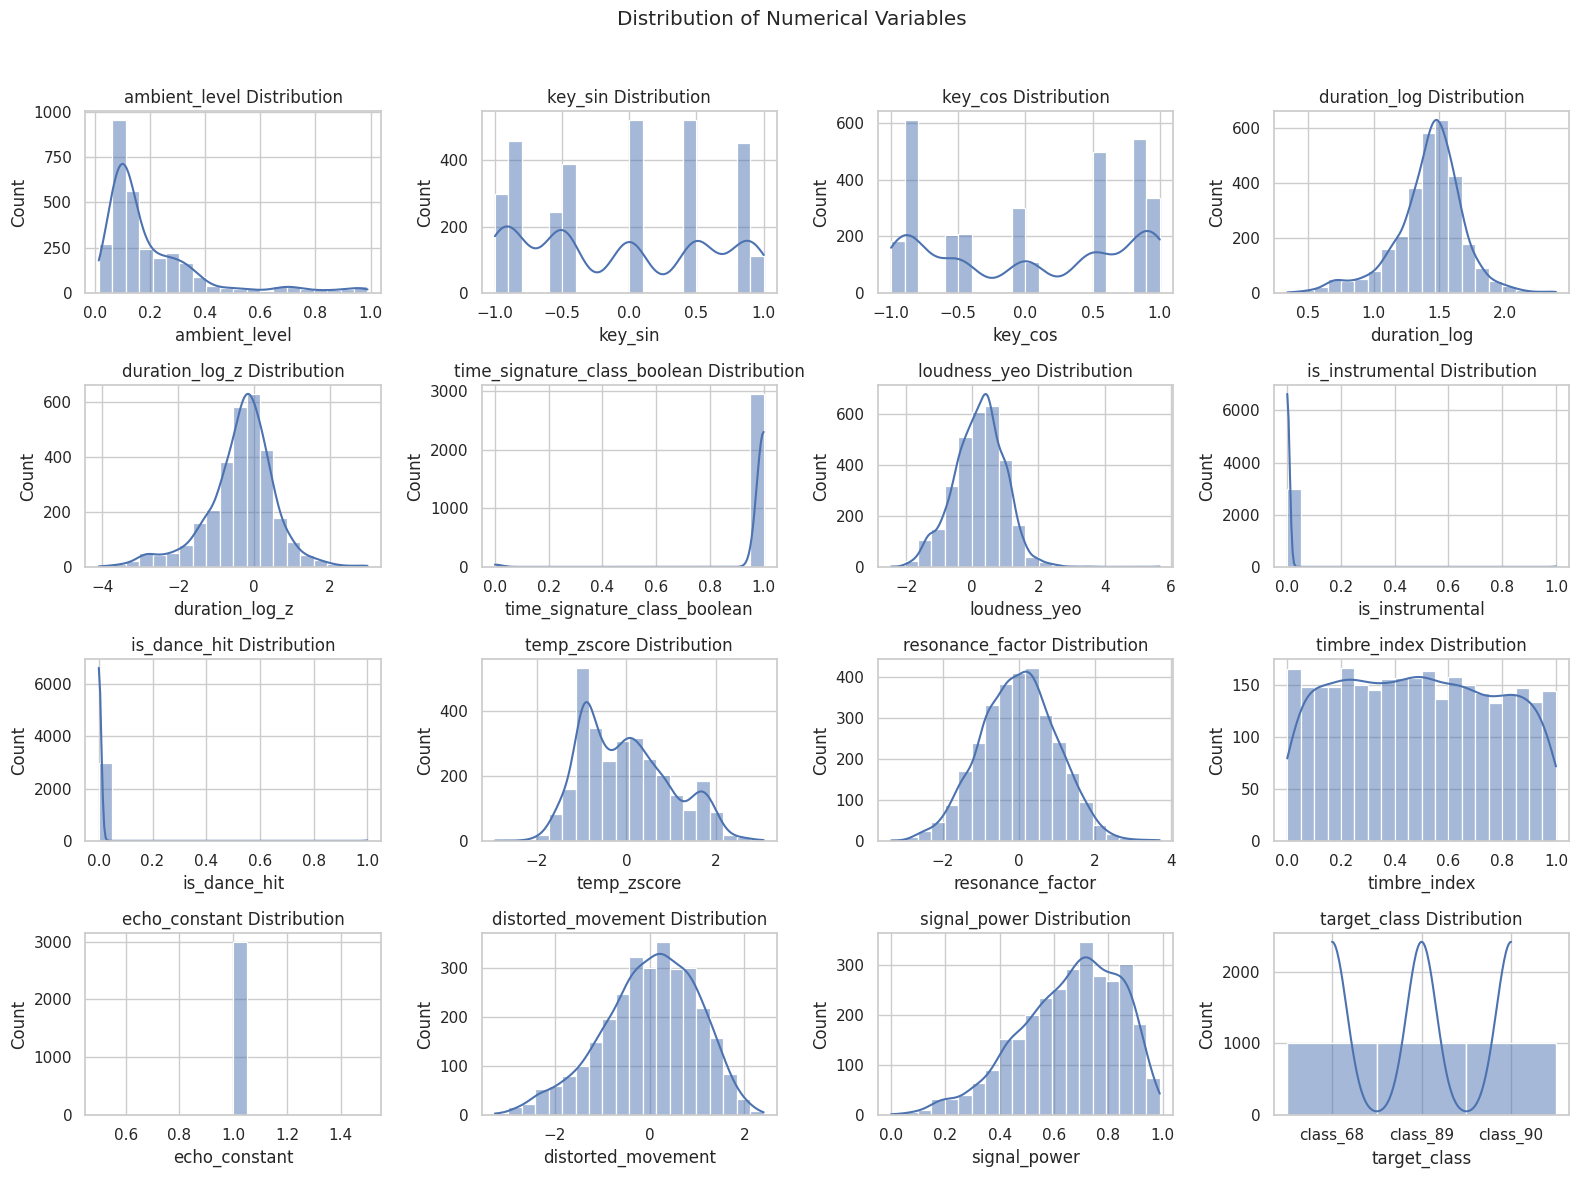

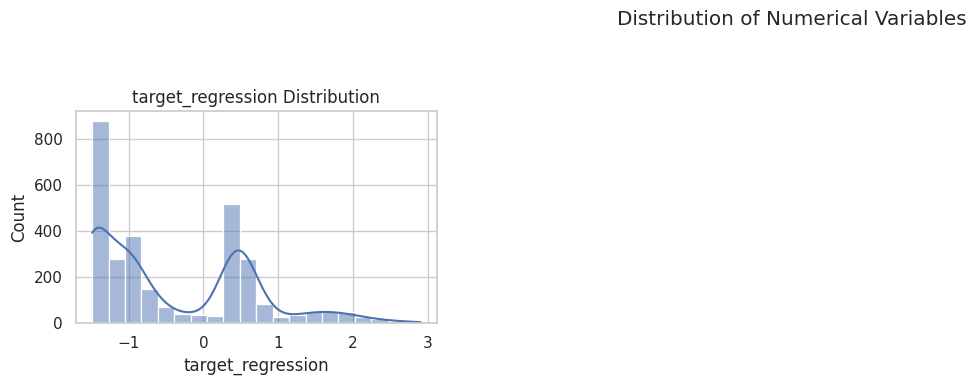

In [221]:
sns.set(style="whitegrid")

# Defines the numeric columns
num_cols_hist = num_cols
# num_cols.difference(['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5'])

# "for" to run all the numeric columns and create the graphic
# grid of 2x2, 4 columns at a time
for i in range(0, len(num_cols_hist), 16):
    cols = num_cols_hist[i:i+16]

    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    fig.suptitle('Distribution of Numerical Variables')

    axes = axes.flatten()
    for ax, col in zip(axes, cols):
        sns.histplot(df[col].dropna(), kde=True, bins=20, ax=ax)
        ax.set_title(f'{col} Distribution')

    for k in range(len(cols), 16):
        fig.delaxes(axes[k])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

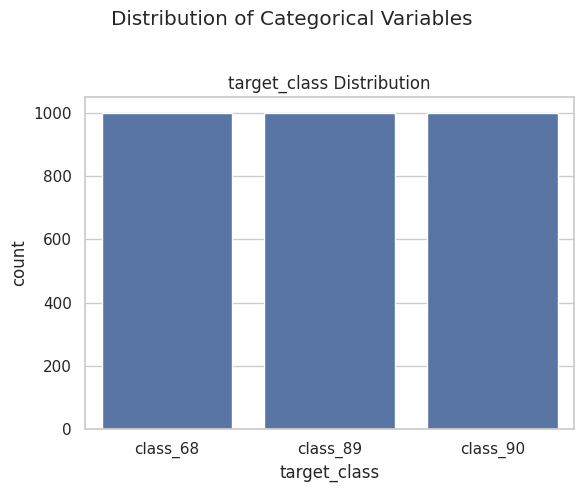

In [222]:
# Plot bar plots for categorical variables
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
fig.suptitle('Distribution of Categorical Variables')

sns.countplot(x='target_class', data=df, ax=axes)
axes.set_title('target_class Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## *3 - Bivariate Analysis*

---
Bivariate analysis studies relationships between **two variables**, especially **individual features** and **target variable**.
Our numeric target variable is **`target_regression`**, that represents the music record's popularity or impact through a numerical score.
For this first bivariate analysis we used a **heatmap**, that relates the numeric variables with the target variable through a correlation coefficient; and **scatter plots**: graphs that use dots to represent the values of two variables; and.


### Correlation matrix



First, we built a heat map to gain more insights in the correlation between numerical features.

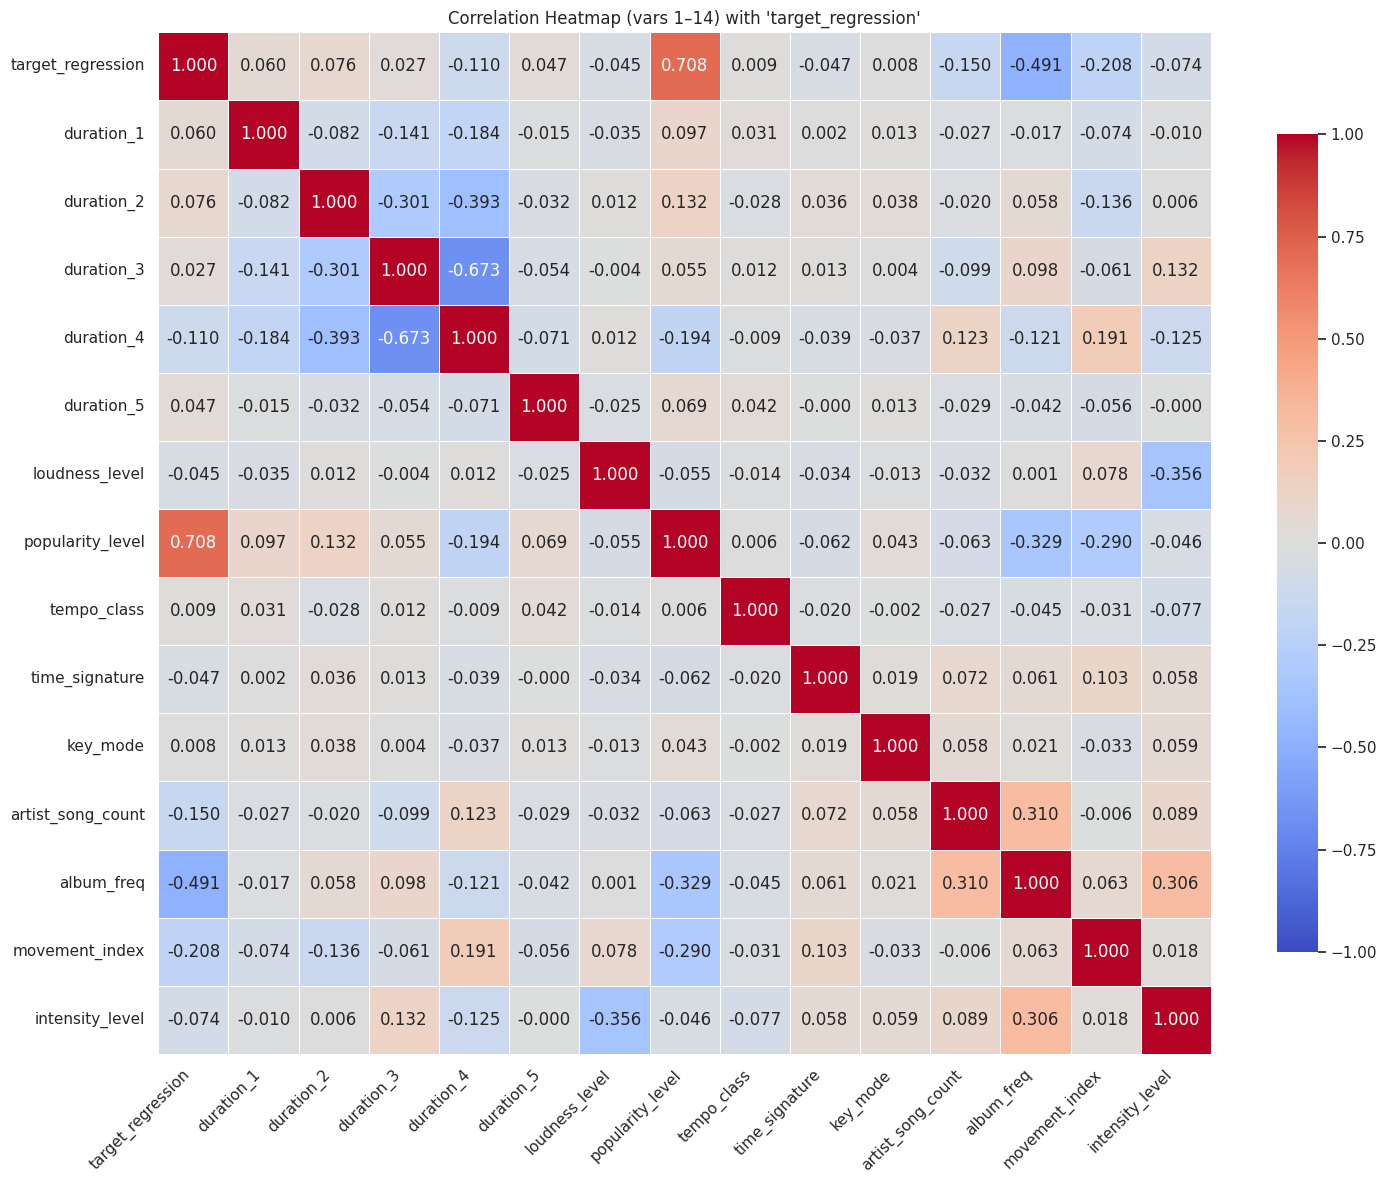

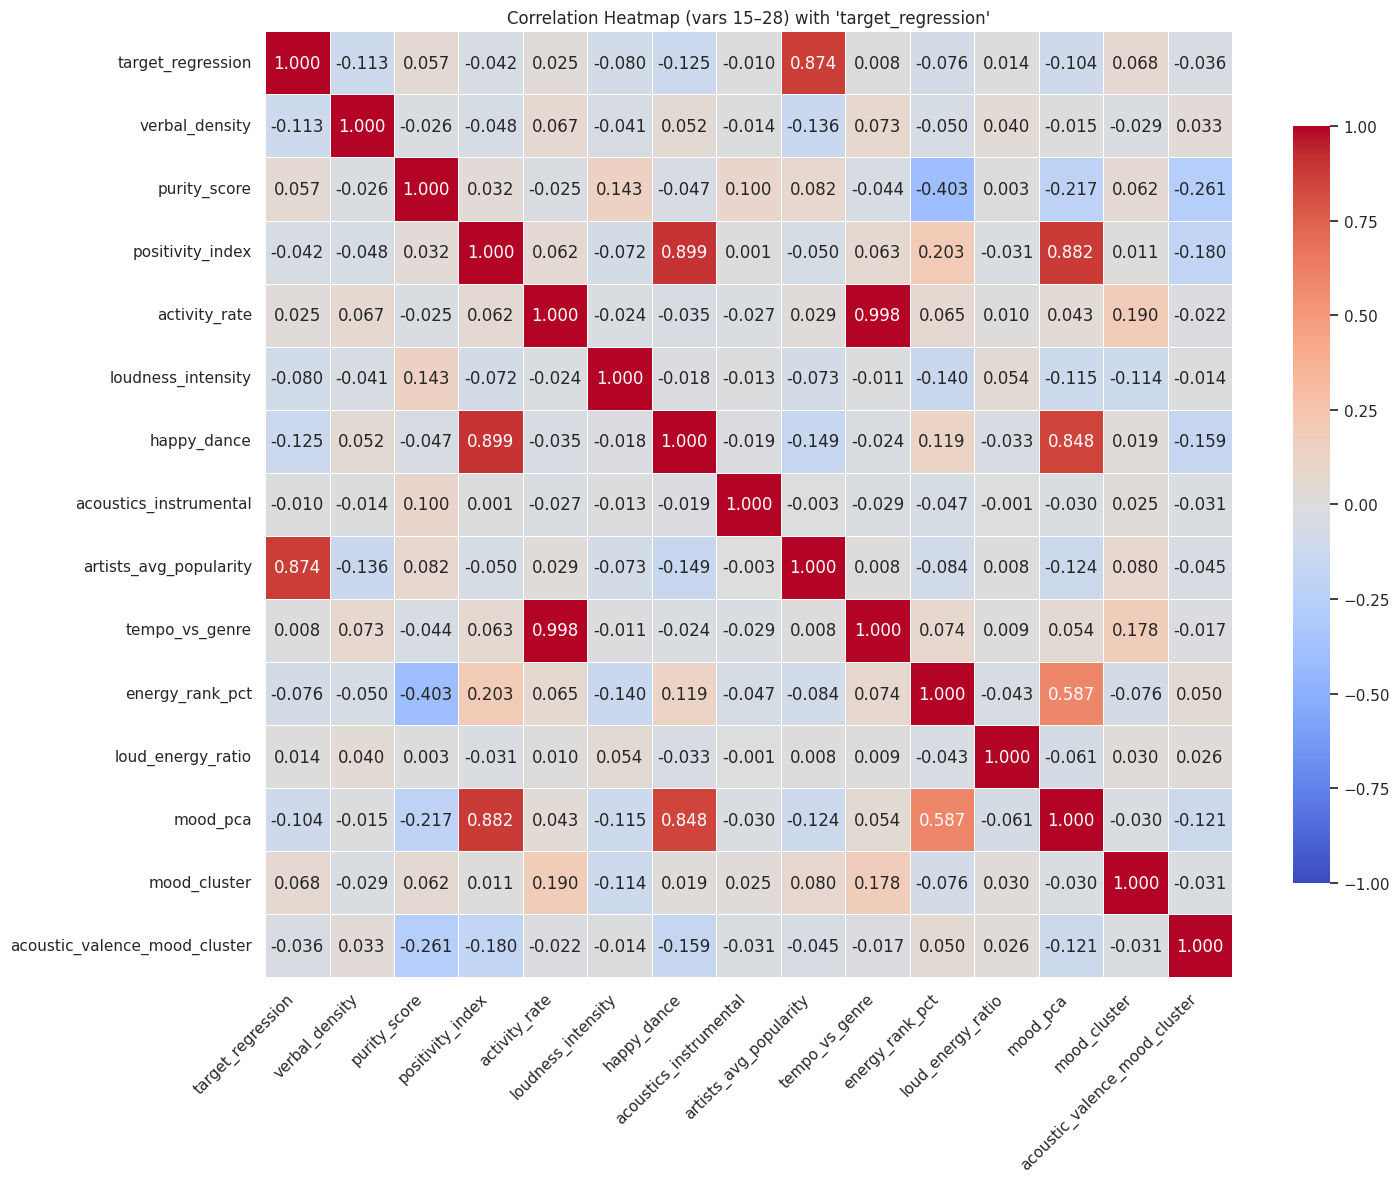

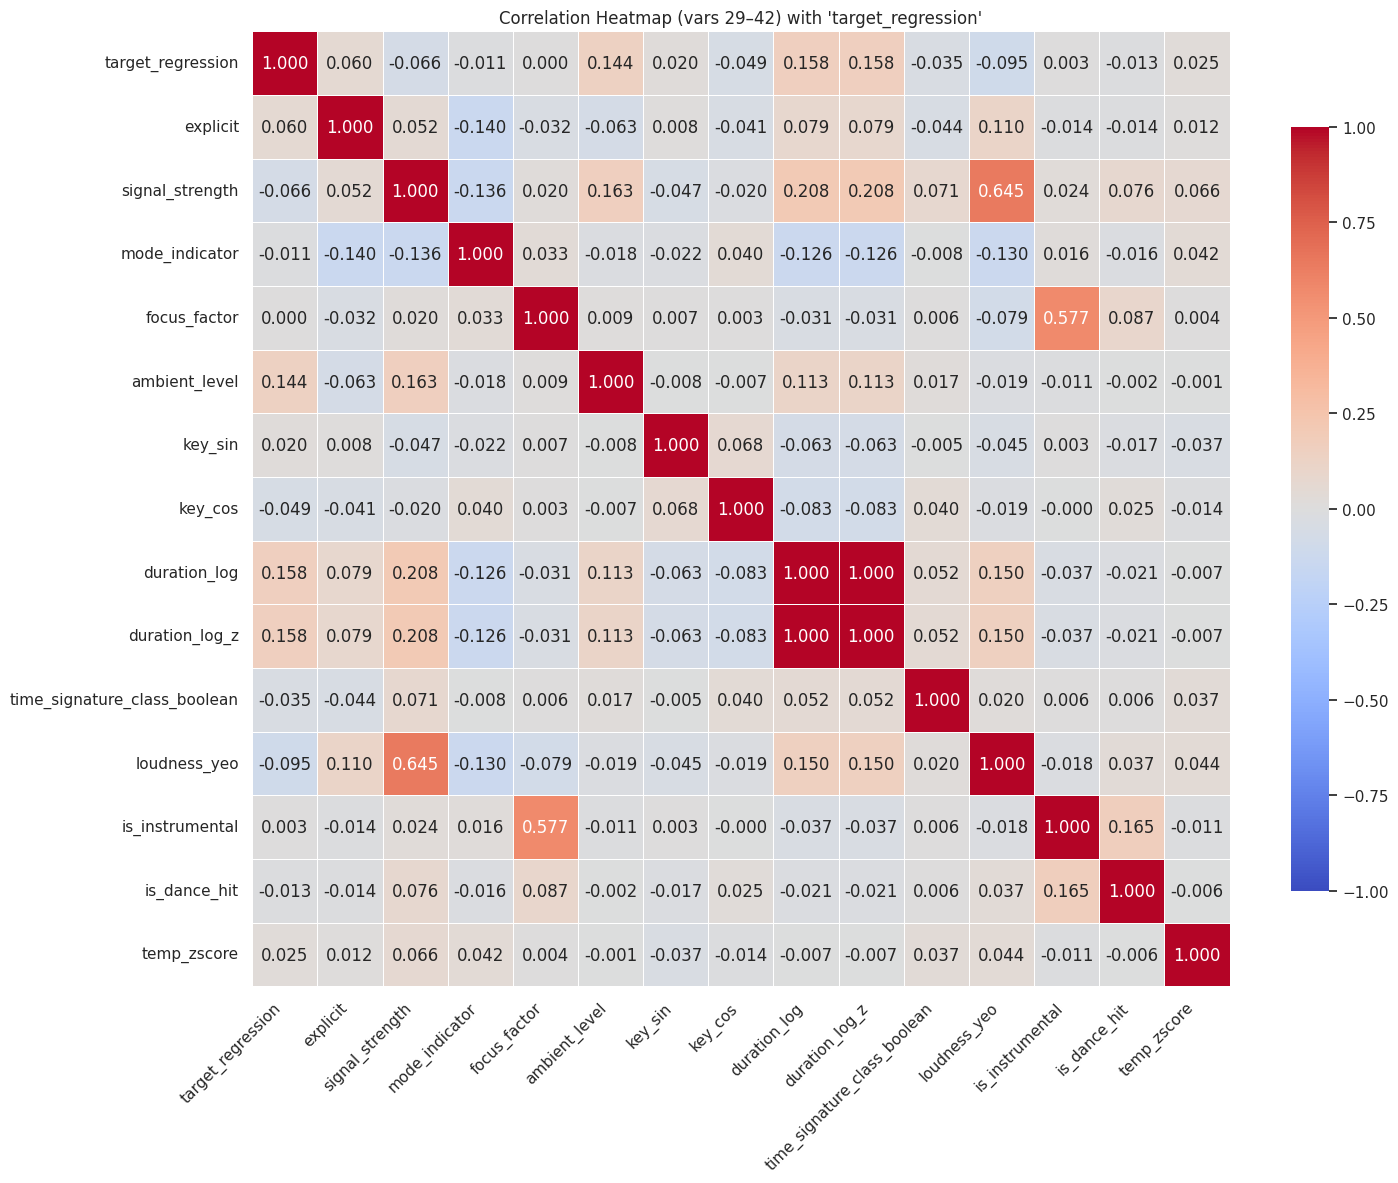

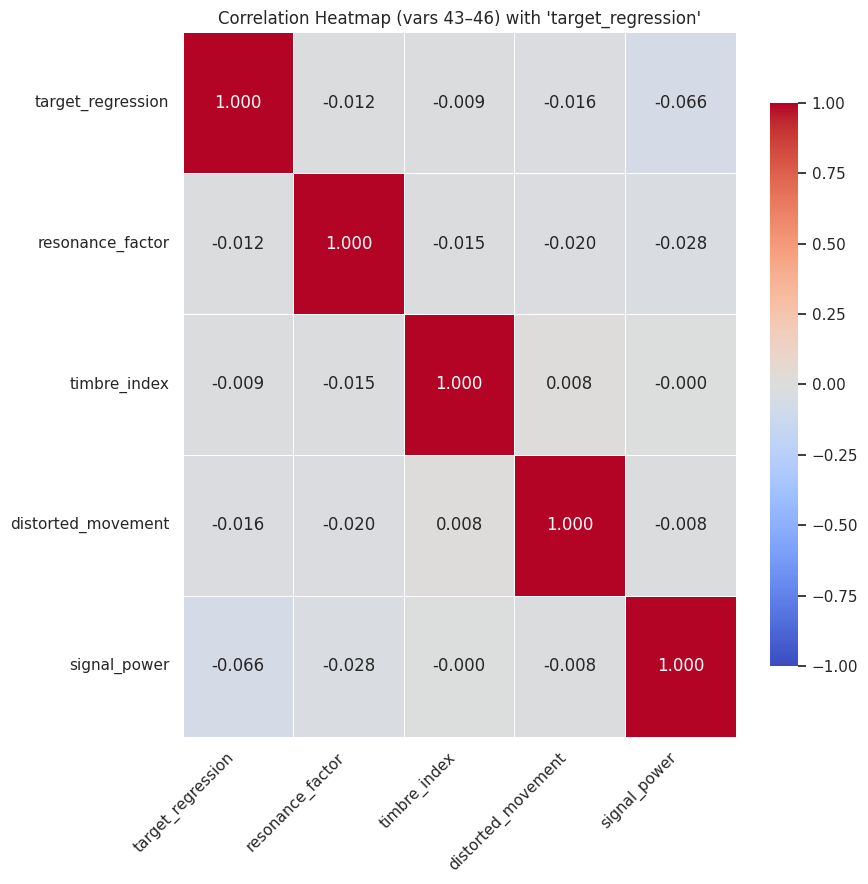

In [223]:
# Fixes the target variable
TARGET = "target_regression"

# Defines the number max of variables per matrix
STEP   = 15

num = df.select_dtypes(include=np.number)
num = num.loc[:, num.nunique(dropna=True) > 1]

# List of the variables, excluding the target one
base_cols = [c for c in num.columns if c != TARGET]

# Loop to create the matrixes
for i in range(0, len(base_cols), STEP-1):
    sub_cols = [TARGET] + base_cols[i:i + (STEP-1)]
    corr = df[sub_cols].corr(method="pearson")

    n = len(sub_cols)
    plt.figure(figsize=(min(6 + 0.6*n, 16), min(6 + 0.6*n, 12)))
    sns.heatmap(
        corr,
        annot=True, fmt=".3f",
        cmap="coolwarm", vmin=-1, vmax=1,
        linewidths=0.5, cbar_kws={"shrink": .8}
    )
    plt.title(f"Correlation Heatmap (vars {i+1}–{i+len(sub_cols)-1}) with '{TARGET}'")
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


**artists_avg_popularity**, **popularity_level**, **album_freq**, **movement_index** and **duration_log** are the top 5 variables with the highest correlation coefficient.
Analysing the scatter plots, there is a strong relation between **artists_avg_popularity** and the numeric target variable (almost linear) and so we can confirm this is the best candidate to the SLR (Simple Linear Regression) model.

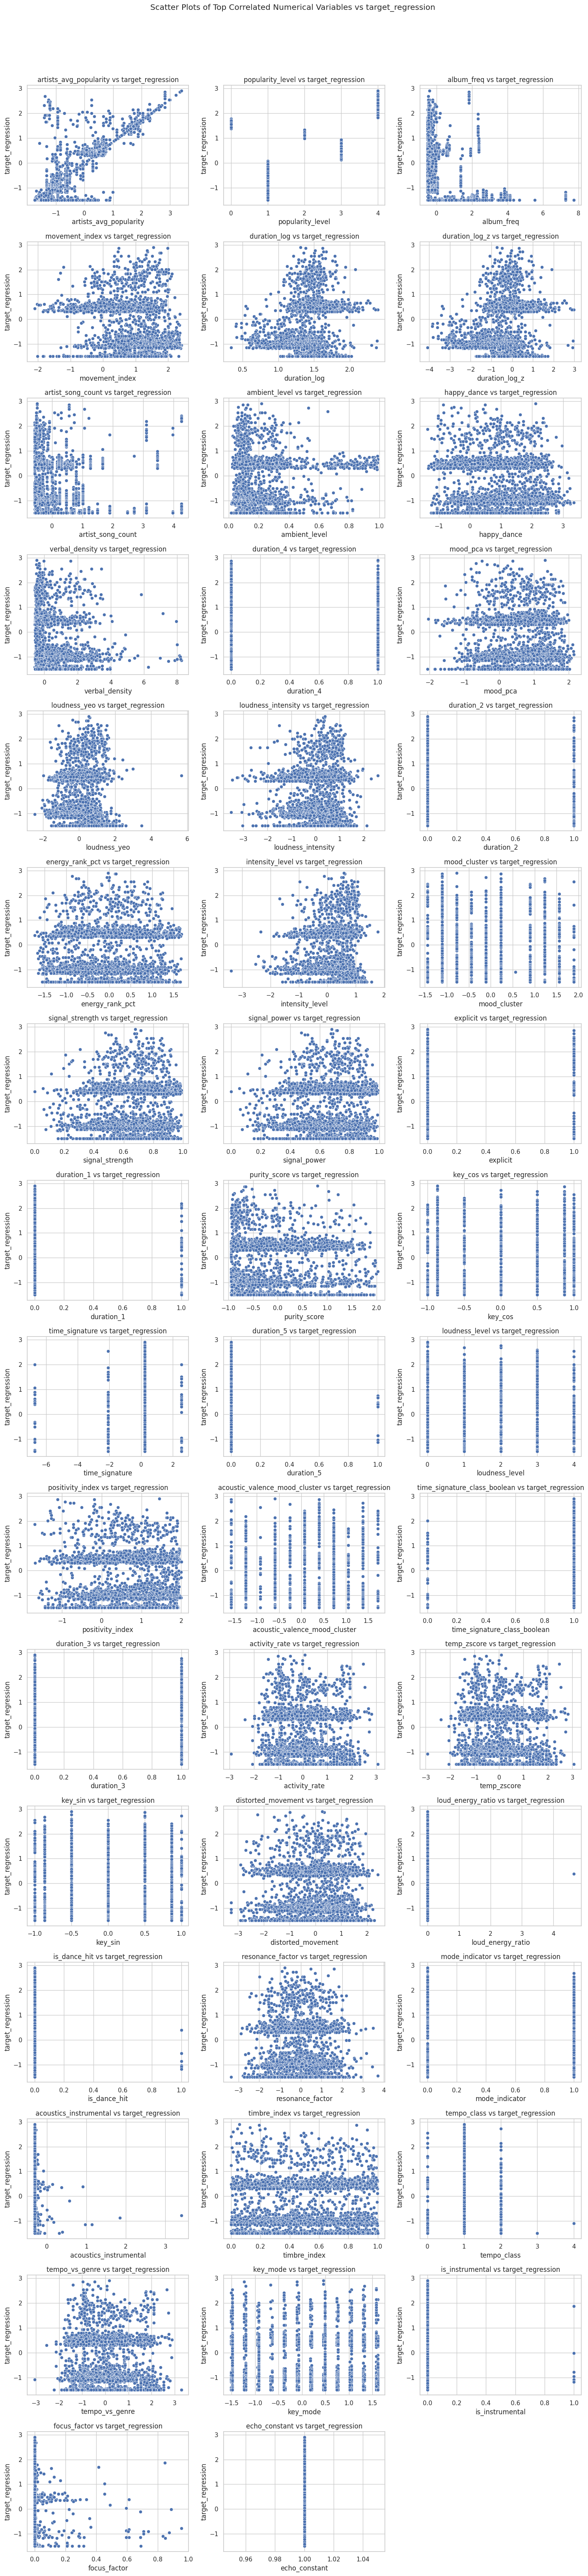

In [224]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('target_regression')

correlation_matrix = df[numerical_cols + ['target_regression']].corr()

selected_features = correlation_matrix['target_regression'].abs().sort_values(ascending=False).index.tolist()
selected_features.remove('target_regression')

n_cols = 3
n_rows = (len(selected_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
fig.suptitle('Scatter Plots of Top Correlated Numerical Variables vs target_regression', y=1.02)
axes = axes.flatten()

for i, col in enumerate(selected_features):
    sns.scatterplot(x=col, y='target_regression', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs target_regression')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('target_regression')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [225]:
top3 = selected_features[:3]
print("Top-3 features:")

print(correlation_matrix['target_regression'].loc[top3].round(3))

Top-3 features:
artists_avg_popularity    0.874
popularity_level          0.708
album_freq               -0.491
Name: target_regression, dtype: float64



For **numeric** and **categorical**, we compare distributions across groups with box plots.  
A box plot is a visual representation of a dataset's distribution, displaying the five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum
**Why it matters for our project:** it highlights predictive signals, warns about redundant features, and guides modeling. Strong yet nonlinear patterns suggest splines or tree-based models. High correlation between features flags multicollinearity to control with feature selection or regularization. Group differences in the target validate useful splits and inform encoding and feature engineering.

The box plots are ranked by the ANOVA correlation ratio (η²)—the fraction of variance explained by the target classes (higher = stronger association).


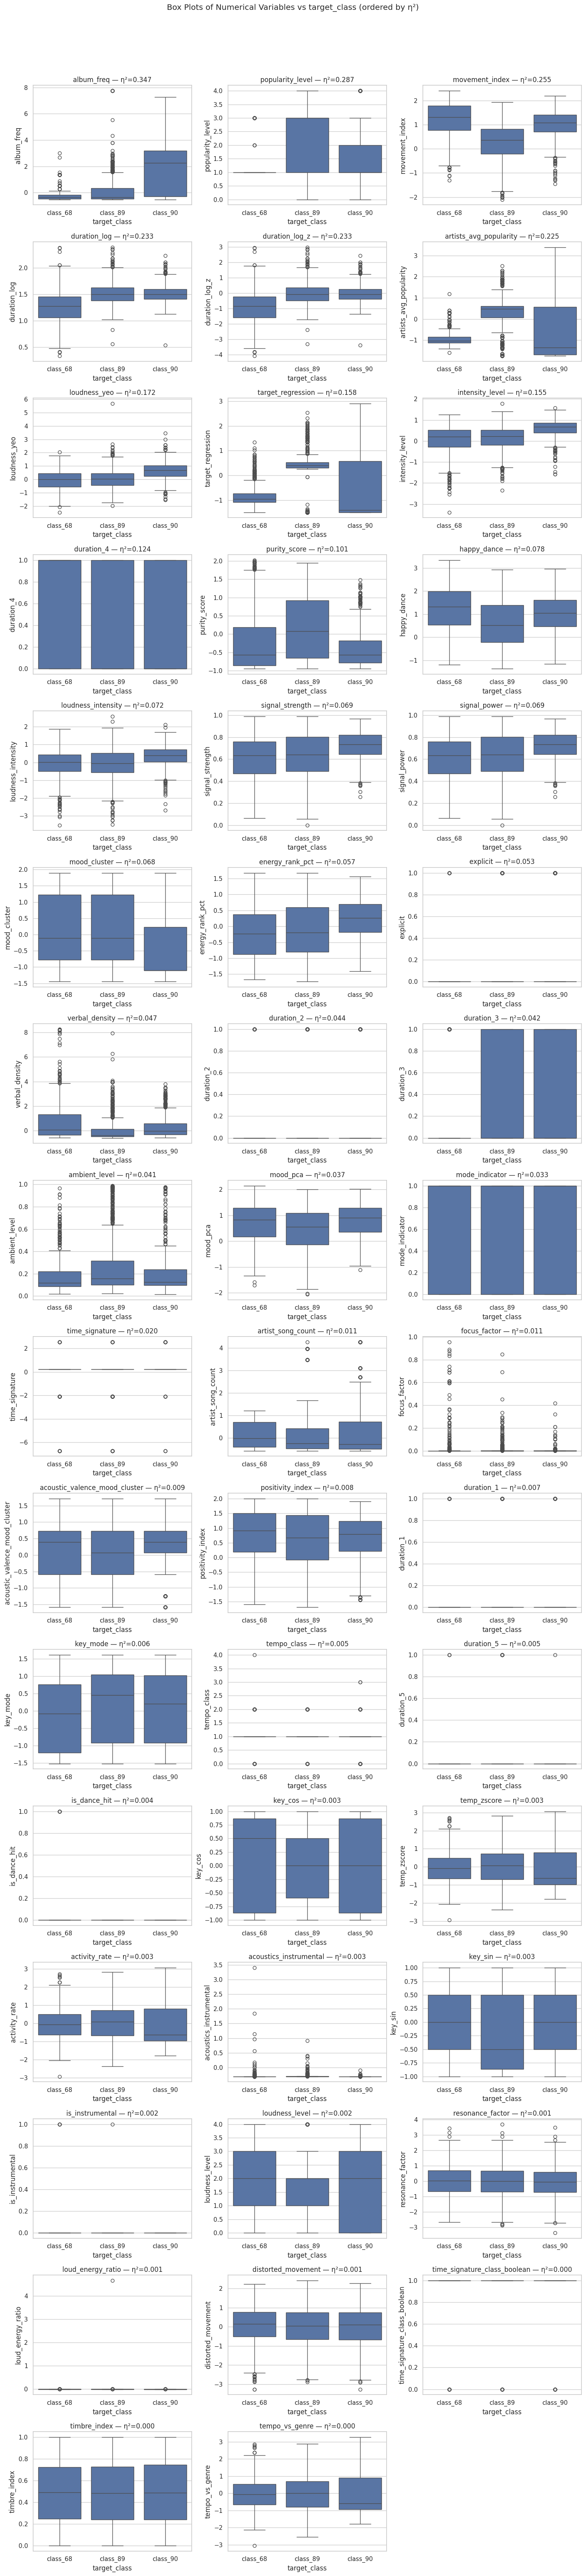

In [226]:
y = df['target_class']

num_cols = df.select_dtypes(include='number').columns
num_cols = [c for c in num_cols if df[c].nunique(dropna=True) > 1 and df[c].notna().sum() > 2]

def eta2_ratio(categories, values):
    mask = ~pd.isna(categories) & ~pd.isna(values)
    categories = np.asarray(categories)[mask]
    values = np.asarray(values)[mask]
    if values.size < 3 or np.var(values) == 0:
        return 0.0
    cats, inv = np.unique(categories, return_inverse=True)
    m = values.mean()
    ssb = sum(((values[inv == k].mean() - m) ** 2) * (inv == k).sum() for k in range(len(cats)))
    sst = ((values - m) ** 2).sum()
    return 0.0 if sst == 0 else float(ssb / sst)

eta2 = {col: eta2_ratio(y.values, df[col].values) for col in num_cols}
ordered = sorted(num_cols, key=lambda c: eta2[c], reverse=True)



n = len(ordered)
if n == 0:
    print("Sem features numéricas válidas para plotar.")
else:
    n_cols = 3
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(-1)
    fig.suptitle('Box Plots of Numerical Variables vs target_class (ordered by η²)', y=1.02)

    for i, col in enumerate(ordered):
        sns.boxplot(x='target_class', y=col, data=df, ax=axes[i])
        axes[i].set_title(f'{col} — η²={eta2[col]:.3f}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Most features show weak class separation (heavy IQR overlap). Clearer signals come from **artist_avg_popularity**, **album_avg_popularity**, **metric_avg_popularity**, and **popularity_level** (shifted medians). Audio traits (energy, danceability, valence, loudness) are moderate. Timing/tonal vars—tempo, duration_ms, time_signature, key, mode—are weak/near-null. Several plots (e.g., instrumentalness, liveness, speechiness) show skew/outliers → prefer robust stats. Next: rank by ω²/η² and prioritize popularity-related features.

## 3. Methods Application — Regression

In this section we model the continuous target variable (`target_regression`), which represents the impact/popularity score of each track. The goal is to predict this numeric outcome from the available audio and metadata features. We develop and evaluate two types of regression models:

1. **Simple Linear Regression**, where the prediction is based on a single feature. We test multiple individual features and identify which one provides the best predictive power.
2. **Multiple Linear Regression**, where the prediction is based on a combination of features. We explore different feature subsets to assess whether using multiple audio descriptors improves performance.

Both models are evaluated using a hold-out strategy, where the dataset is split into a training set (to fit the model) and a test set (to assess generalization). We report standard regression metrics — such as R², MAE, and RMSE — and compare the models to understand the trade-off between simplicity (one feature, easy to interpret) and complexity (multiple features, potentially higher accuracy).


### 3.1 Simple Linear Regression

In this step we build a Simple Linear Regression (SLR) model, where we try to predict the continuous target (`target_regression`) using only a single explanatory feature. In this case, we use the top 3 features(`artists_avg_popularity`,`album_freq` and `popularity_level`). The goal is to understand how strongly each individual feature is related to the target and how well it can explain the variation in the popularity/impact score on its own.

artists_avg_popularity - target_regression
Slope: 0.873756
Intercept: -0.010184
Mean Absolute Error (MAE): 0.2523
Residual Mean Squared Error (MSE): 0.2539
R2-score: 0.7637
------------------------------------------------------------


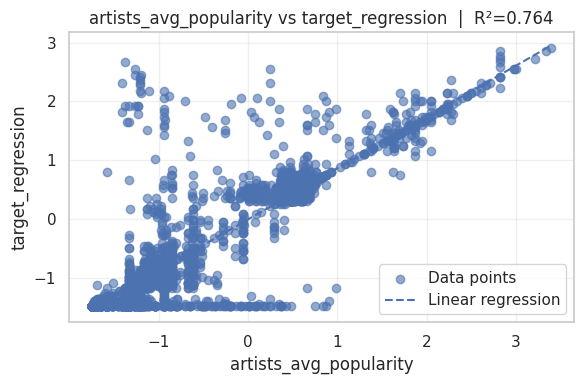

popularity_level - target_regression
Slope: 0.703079
Intercept: -1.603219
Mean Absolute Error (MAE): 0.4329
Residual Mean Squared Error (MSE): 0.5353
R2-score: 0.5018
------------------------------------------------------------


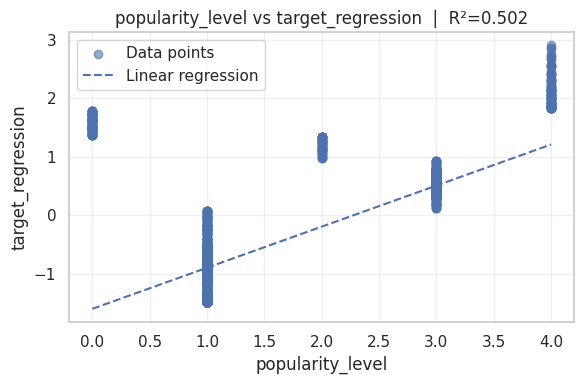

album_freq - target_regression
Slope: -0.312882
Intercept: -0.223575
Mean Absolute Error (MAE): 0.7604
Residual Mean Squared Error (MSE): 0.8153
R2-score: 0.2412
------------------------------------------------------------


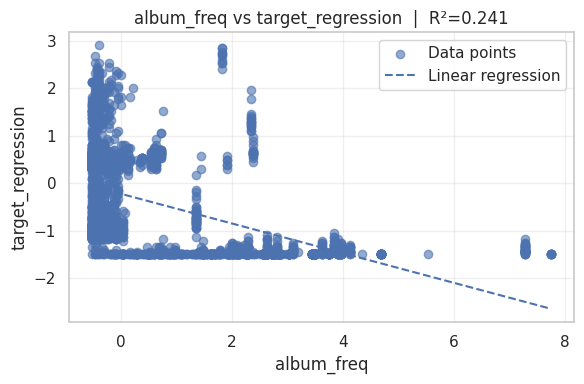


Simple Linear Regression Results:


Feature        R2
0  artists_avg_popularity  0.763689
1        popularity_level  0.501804
2              album_freq  0.241191

In [227]:
TARGET = "target_regression"

# Select features for analysis - use top3 if available, otherwise first 3 from selected_features
features_to_run = [f for f in (top3 if 'top3' in globals() else selected_features[:3]) if f != TARGET][:3]

# Initialize list to store regression results
slr_results_list = [] # List to store results

# Perform simple linear regression for each selected feature
for feat in features_to_run:

    # Prepare data by removing missing values for current feature-target pair
    d = df[[feat, TARGET]].dropna()
    X = d[[feat]].values
    y = d[TARGET].values

    # Fit linear regression model
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0]
    intercept = lr.intercept_

    # Generate predictions and calculate residuals
    y_pred = lr.predict(X).ravel()
    resid  = y - y_pred

    # Calculate evaluation metrics
    mae = np.mean(np.abs(resid))
    mse = np.mean(resid**2)
    r2  = r2_score(y, y_pred)

    print(f"{feat} - {TARGET}")
    print(f"Slope: {slope:.6f}")
    print(f"Intercept: {intercept:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Residual Mean Squared Error (MSE): {mse:.4f}")
    print(f"R2-score: {r2:.4f}")
    print("-"*60)

    # Store results in the list
    slr_results_list.append({'Feature': feat, 'R2': r2})

    # Create visualization: scatter plot with regression line
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, alpha=0.6, label='Data points')
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_line = lr.predict(x_line)
    plt.plot(x_line, y_line, '--', label='Linear regression')
    plt.title(f"{feat} vs {TARGET}  |  R²={r2:.3f}")
    plt.xlabel(feat); plt.ylabel(TARGET)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Convert the list of results to a DataFrame
slr_results = pd.DataFrame(slr_results_list)

# Display the results table
print("\nSimple Linear Regression Results:")
display(slr_results.sort_values(by='R2', ascending=False))

Visualize predicitons of Simple Linear Regression

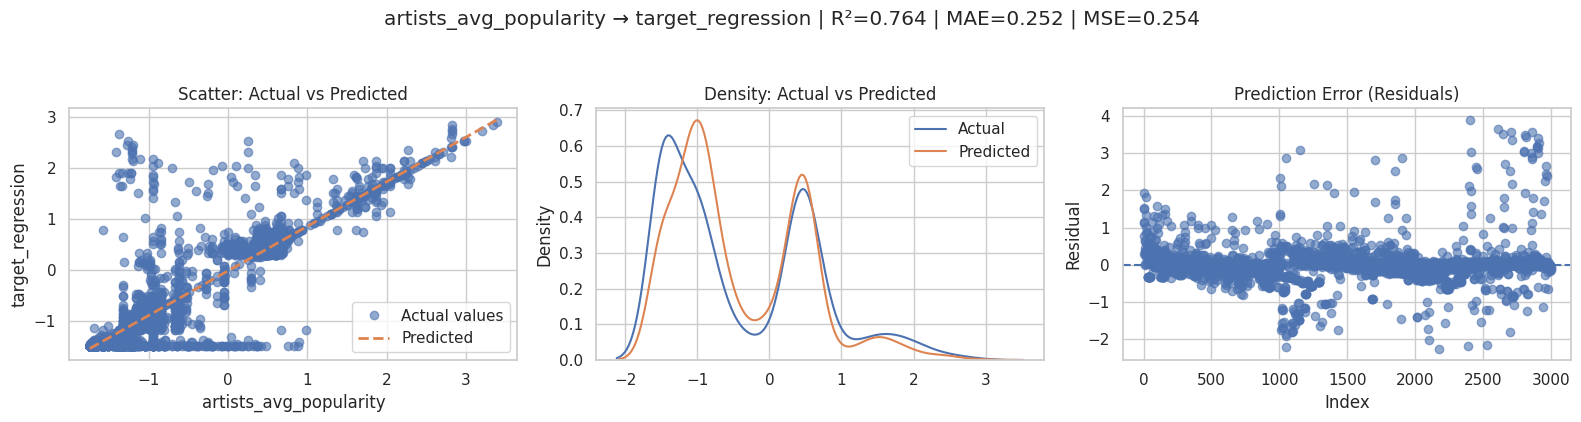

Feature: artists_avg_popularity
  Slope: 0.873756
  Intercept: -0.010184
  MAE: 0.2523 | MSE: 0.2539 | R²: 0.7637
------------------------------------------------------------


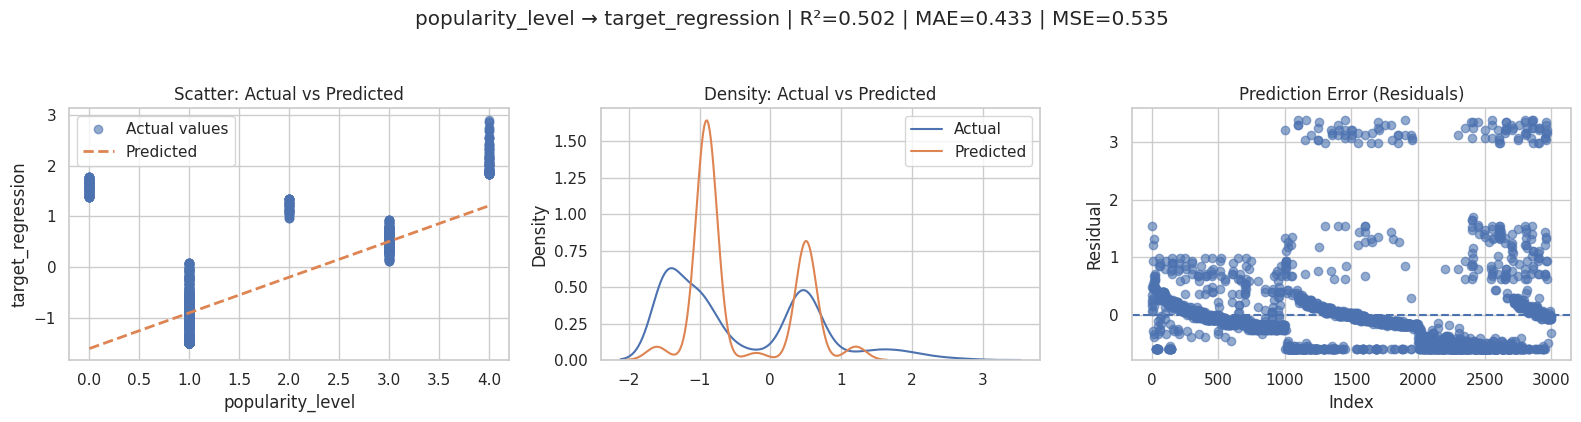

Feature: popularity_level
  Slope: 0.703079
  Intercept: -1.603219
  MAE: 0.4329 | MSE: 0.5353 | R²: 0.5018
------------------------------------------------------------


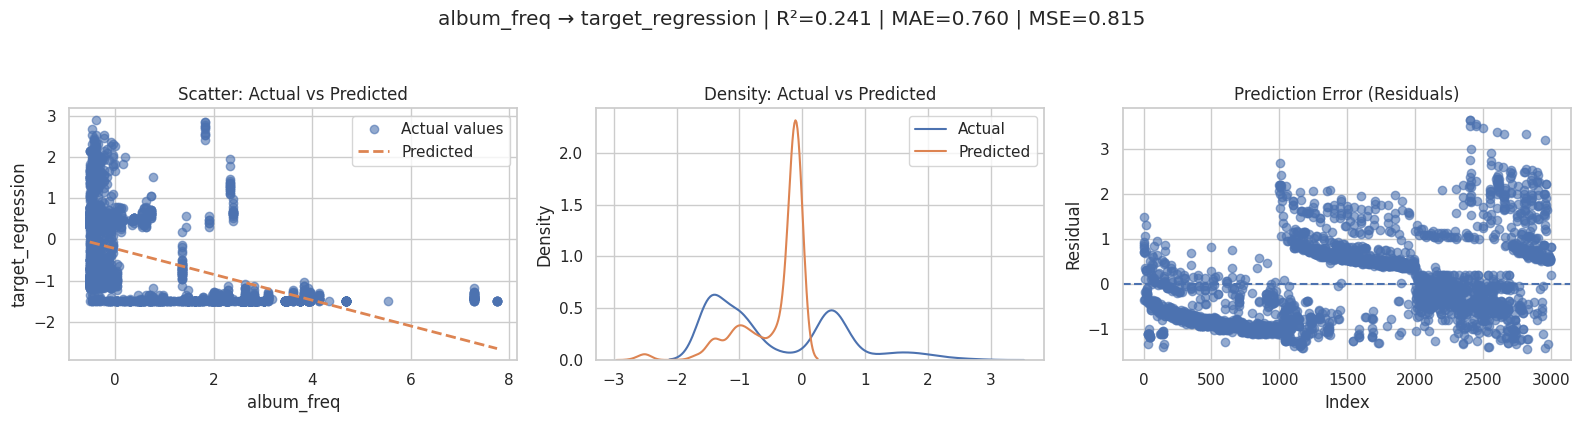

Feature: album_freq
  Slope: -0.312882
  Intercept: -0.223575
  MAE: 0.7604 | MSE: 0.8153 | R²: 0.2412
------------------------------------------------------------


In [228]:
def plot_slr_diagnostics(df, feature, TARGET=TARGET):
    d = df[[feature, TARGET]].dropna()
    X = d[[feature]].values
    y = d[TARGET].values

    # Model
    lr = LinearRegression().fit(X, y)
    y_pred = lr.predict(X).ravel()
    resid  = y - y_pred

    # Metrics
    r2  = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Actual vs Predicted
    axes[0].plot(d[feature], y, 'o', label='Actual values', alpha=0.6)
    order = np.argsort(X.ravel())
    axes[0].plot(d[feature].values[order], y_pred[order], '--', label='Predicted', linewidth=2)
    axes[0].set_title("Scatter: Actual vs Predicted")
    axes[0].set_xlabel(feature); axes[0].set_ylabel(TARGET)
    axes[0].legend()

    # Density (Actual vs Predicted)
    sns.kdeplot(y, label="Actual", ax=axes[1])
    sns.kdeplot(y_pred, label="Predicted", ax=axes[1])
    axes[1].set_title("Density: Actual vs Predicted")
    axes[1].legend()

    # Residuals
    axes[2].scatter(d.index, resid, alpha=0.6)
    axes[2].axhline(0, linestyle='--')
    axes[2].set_title("Prediction Error (Residuals)")
    axes[2].set_xlabel("Index"); axes[2].set_ylabel("Residual")

    fig.suptitle(f"{feature} → {TARGET} | R²={r2:.3f} | MAE={mae:.3f} | MSE={mse:.3f}", y=1.05)
    fig.tight_layout()
    plt.show()

    print(f"Feature: {feature}")
    print(f"  Slope: {lr.coef_[0]:.6f}")
    print(f"  Intercept: {lr.intercept_:.6f}")
    print(f"  MAE: {mae:.4f} | MSE: {mse:.4f} | R²: {r2:.4f}")
    print("-"*60)


features_to_run = [f for f in (top3 if 'top3' in globals() else selected_features[:3]) if f != TARGET][:3]

for feat in features_to_run:
    plot_slr_diagnostics(df, feat, TARGET=TARGET)

### 3.2 Multiple Linear Regression

Available features for MLR: 3
MLR feature groups configuration:
  Best Single: ['artists_avg_popularity']
  Top 3: ['artists_avg_popularity', 'popularity_level', 'album_freq']
  Top 5: ['artists_avg_popularity', 'popularity_level', 'album_freq', 'movement_index', 'duration_log']
  Top 10: ['artists_avg_popularity', 'popularity_level', 'album_freq', 'movement_index', 'duration_log', 'duration_log_z', 'artist_song_count', 'ambient_level', 'happy_dance', 'verbal_density']

=== Multiple Linear Regression Performance Summary ===


Feature Set  Feature Count  Training R2   Test R2  Test MAE  Test RMSE
0  Best Single              1     0.753632  0.788363  0.235982   0.466322
1        Top 3              3     0.803578  0.828402  0.243692   0.419901
2        Top 5              5     0.804822  0.831236  0.242979   0.416419
3       Top 10             10     0.806324  0.831243  0.248175   0.416410


Optimal feature set: Top 10
Feature Set        Top 10
Feature Count          10
Training R2      0.806324
Test R2          0.831243
Test MAE         0.248175
Test RMSE         0.41641
Name: 3, dtype: object


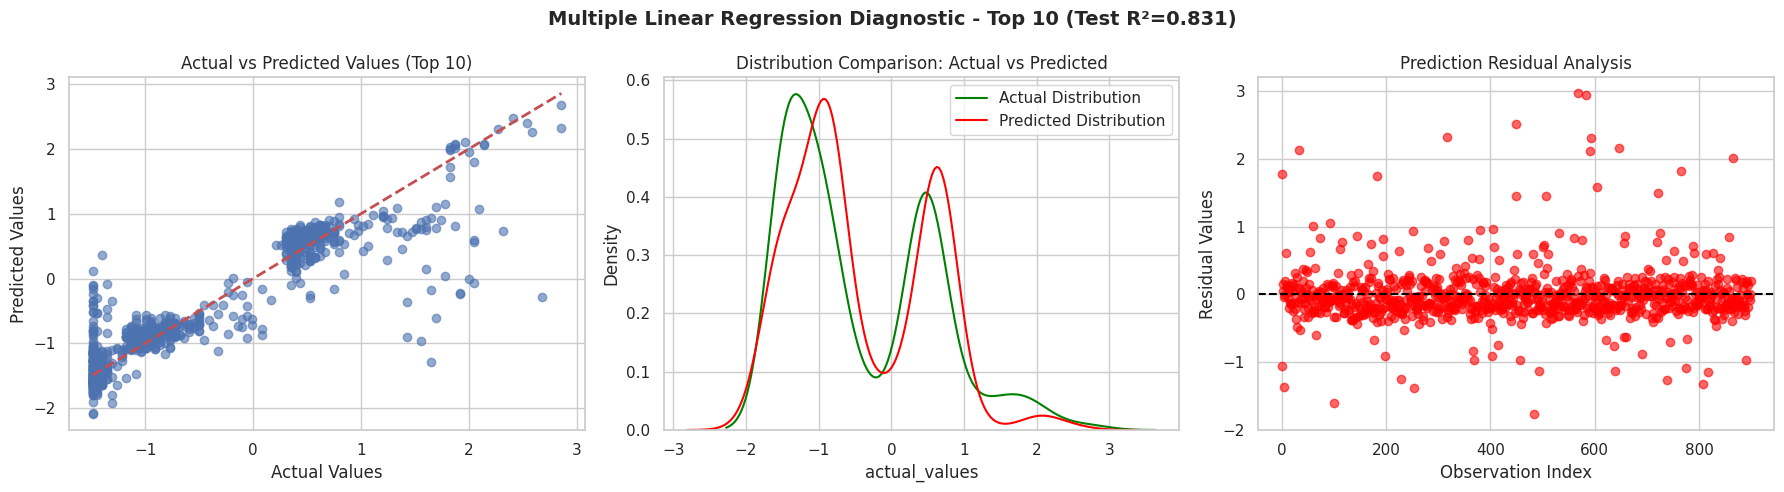


Feature coefficients for Top 10 model:


Feature  Regression Coefficient
0  artists_avg_popularity                0.708157
1        popularity_level                0.256168
2              album_freq               -0.135045
3          movement_index                0.050640
6       artist_song_count                0.036809
8             happy_dance               -0.023228
9          verbal_density                0.013109
7           ambient_level               -0.009712
5          duration_log_z                0.002774
4            duration_log                0.002774


=== PERFORMANCE COMPARISON: SINGLE vs MULTIPLE LINEAR REGRESSION ===
Best Single Feature Regression R²: 0.7637
Best Multiple Regression R² (Top 10): 0.8312
Performance improvement: 0.0676 (8.8%)

Comparative analysis of all feature sets:
  Best Single (1 features): Test R² = 0.7884
  Top 3 (3 features): Test R² = 0.8284
  Top 5 (5 features): Test R² = 0.8312
  Top 10 (10 features): Test R² = 0.8312

Note: 47 features available in selection.
Consider running SLR analysis on additional features to expand MLR options.


In [229]:
# Check available features count
available_features_count = len(slr_results)
print(f"Available features for MLR: {available_features_count}")

# Create feature groups based on actual availability
mlr_feature_groups = {}

# Include best single feature (Top 1)
if available_features_count >= 1:
    mlr_feature_groups['Best Single'] = slr_results.head(1)['Feature'].tolist()

# Add other groups based on availability
if available_features_count >= 3:
    mlr_feature_groups['Top 3'] = slr_results.head(3)['Feature'].tolist()
elif available_features_count >= 2:
    mlr_feature_groups[f'Top {available_features_count}'] = slr_results.head(available_features_count)['Feature'].tolist()

# Include larger feature sets if available
if 'selected_features' in globals() and len(selected_features) > 3:
    candidate_features = [f for f in selected_features if f != TARGET]
    if len(candidate_features) >= 5:
        mlr_feature_groups['Top 5'] = candidate_features[:5]
    if len(candidate_features) >= 10:
        mlr_feature_groups['Top 10'] = candidate_features[:10]

print("MLR feature groups configuration:")
for group_name, features in mlr_feature_groups.items():
    print(f"  {group_name}: {features}")

# Evaluate MLR models for each feature group
mlr_performance_results = []

for group_name, features in mlr_feature_groups.items():
    if len(features) == 0:
        continue

    # Ensure valid data availability
    clean_data = df[features + [TARGET]].dropna()
    if len(clean_data) < 10:  # Minimum sample threshold
        print(f"Warning: Group {group_name} has insufficient data after NaN removal. Skipping.")
        continue

    X = clean_data[features]
    y = clean_data[TARGET]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Feature scaling
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # MLR model training
    mlr_model = LinearRegression()
    mlr_model.fit(X_train_scaled, y_train)

    # Generate predictions
    train_predictions = mlr_model.predict(X_train_scaled)
    test_predictions = mlr_model.predict(X_test_scaled)

    # Calculate performance metrics
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    # Store results
    mlr_performance_results.append([
        group_name, len(features),
        train_r2, test_r2, test_mae, test_rmse
    ])

# Create results summary
if mlr_performance_results:
    mlr_results_summary = pd.DataFrame(mlr_performance_results, columns=[
        'Feature Set', 'Feature Count',
        'Training R2', 'Test R2', 'Test MAE', 'Test RMSE'
    ])

    print("\n=== Multiple Linear Regression Performance Summary ===")
    display(mlr_results_summary)

    # Identify optimal feature set
    best_performing_set = mlr_results_summary.loc[mlr_results_summary['Test R2'].idxmax()]
    best_set_name = best_performing_set['Feature Set']
    print(f"\nOptimal feature set: {best_set_name}")
    print(best_performing_set)

    # Visualization for best performing model
    best_features = mlr_feature_groups[best_set_name]

    # Prepare data for final model
    final_data = df[best_features + [TARGET]].dropna()
    X_final = final_data[best_features]
    y_final = final_data[TARGET]

    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
        X_final, y_final, test_size=0.3, random_state=42
    )
    final_scaler = StandardScaler()
    X_train_scaled_final = final_scaler.fit_transform(X_train_final)
    X_test_scaled_final = final_scaler.transform(X_test_final)

    # Train final model
    final_mlr_model = LinearRegression().fit(X_train_scaled_final, y_train_final)
    final_predictions = final_mlr_model.predict(X_test_scaled_final)

    # Create visualization dataset
    viz_data = pd.DataFrame({
        'actual_values': y_test_final,
        'predicted_values': final_predictions,
        'prediction_errors': y_test_final - final_predictions
    }).reset_index(drop=True)

    # Generate diagnostic plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Actual vs predicted scatter plot
    axes[0].scatter(viz_data['actual_values'], viz_data['predicted_values'], alpha=0.6)
    axes[0].plot([viz_data['actual_values'].min(), viz_data['actual_values'].max()],
                 [viz_data['actual_values'].min(), viz_data['actual_values'].max()], 'r--', lw=2)
    axes[0].set_title(f"Actual vs Predicted Values ({best_set_name})")
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predicted Values")

    # Distribution comparison
    sns.kdeplot(viz_data['actual_values'], color="green", label="Actual Distribution", ax=axes[1])
    sns.kdeplot(viz_data['predicted_values'], color="red", label="Predicted Distribution", ax=axes[1])
    axes[1].set_title("Distribution Comparison: Actual vs Predicted")
    axes[1].legend()

    # Residual analysis
    axes[2].scatter(viz_data.index, viz_data['prediction_errors'], alpha=0.6, color="red")
    axes[2].axhline(0, linestyle='--', color='black')
    axes[2].set_title("Prediction Residual Analysis")
    axes[2].set_xlabel("Observation Index")
    axes[2].set_ylabel("Residual Values")

    fig.suptitle(f"Multiple Linear Regression Diagnostic - {best_set_name} (Test R²={best_performing_set['Test R2']:.3f})",
                 fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

    # Display model coefficients
    feature_importance = pd.DataFrame({
        'Feature': best_features,
        'Regression Coefficient': final_mlr_model.coef_
    }).sort_values('Regression Coefficient', key=abs, ascending=False)

    print(f"\nFeature coefficients for {best_set_name} model:")
    display(feature_importance)

    # SLR vs MLR performance comparison
    print(f"\n=== PERFORMANCE COMPARISON: SINGLE vs MULTIPLE LINEAR REGRESSION ===")
    best_slr_performance = slr_results['R2'].max()
    best_mlr_performance = best_performing_set['Test R2']
    performance_gain = best_mlr_performance - best_slr_performance

    print(f"Best Single Feature Regression R²: {best_slr_performance:.4f}")
    print(f"Best Multiple Regression R² ({best_set_name}): {best_mlr_performance:.4f}")
    print(f"Performance improvement: {performance_gain:.4f} ({performance_gain/best_slr_performance*100:.1f}%)")

    # Comparative analysis of all feature sets
    if len(mlr_results_summary) > 1:
        print(f"\nComparative analysis of all feature sets:")
        for _, result_row in mlr_results_summary.iterrows():
            print(f"  {result_row['Feature Set']} ({result_row['Feature Count']} features): Test R² = {result_row['Test R2']:.4f}")

else:
    print("No feature sets could be processed. Please verify data availability.")

# Recommendation for expanded analysis
if 'selected_features' in globals() and len(selected_features) > 3:
    print(f"\nNote: {len(selected_features)} features available in selection.")
    print("Consider running SLR analysis on additional features to expand MLR options.")

## 4. Methods Application — Classification

In [230]:
TARGET = "target_class"

scaler = StandardScaler()

# numeric candidate features (drop the target itself)
num_cols = df.select_dtypes(include="number").columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

# hold-out split (stratified to respect class proportions)
X = df[num_cols].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [231]:
model = LogisticRegression(solver='liblinear', C=0.05,
                           random_state=0)

### 4.1 Logistic Regression

We fit a multinomial Logistic Regression model to predict the categorical target `target_class` from the selected audio features.

#### 4.1.1 Hold-out

In [232]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy (test): {:.2%}". format(accuracy_score(y_test, y_pred)))
print("F1-macro (test): {:.2%}".format(f1_score(y_test, y_pred, average="macro")))

Accuracy (test): 84.56%
F1-macro (test): 84.41%


#### 4.1.2 K-Fold Cross Validation (k = 5 & k = 10)

In [233]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 71.93% (±22.02%)
Scores:  [0.84       0.83666667 0.64166667 0.91       0.36833333]


In [234]:
k_folds = KFold(n_splits = 10)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 79.87% (±21.36%)
Scores:  [0.85666667 0.97       0.93333333 0.70666667 0.78333333 0.84333333
 0.91       0.94333333 0.80333333 0.23666667]


#### 4.1.3 Leave One Out Cross Validation (LOOCV)

In [235]:
cv = LeaveOneOut()

scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))

Accuracy: 87.03% (±33.60%)


#### 4.1.4 Bootstrap

In [236]:
# Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Parameters
n_bootstrap = 100
rng = np.random.default_rng(42)

accs, f1s = [], []
n = len(X)

for _ in range(n_bootstrap):
    idx = rng.integers(0, n, n)
    oob = np.setdiff1d(np.arange(n), idx)
    if len(oob) == 0:
        continue

    Xtr, ytr = X.iloc[idx], y.iloc[idx]
    Xte, yte = X.iloc[oob], y.iloc[oob]

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    model.fit(Xtr_s, ytr)
    yhat = model.predict(Xte_s)

    accs.append(accuracy_score(yte, yhat))
    f1s.append(f1_score(yte, yhat, average="macro"))

accs = np.array(accs)
f1s  = np.array(f1s)

print(f"Accuracy: {accs.mean()*100:.2f}% (±{accs.std(ddof=1)*100:.2f}%)")
print(f"F1-macro: {f1s.mean()*100:.2f}% (±{f1s.std(ddof=1)*100:.2f}%)")


Accuracy: 97.82% (±0.97%)
F1-macro: 97.65% (±1.05%)


### 4.2 Linear Discriminant Analysis (LDA)

We fit an **LDA** classifier to predict `target_class` using selected audio features (e.g., `artists_avg_popularity`, `album_freq`, `popularity_level` *Texto em itálico*).  
**Assumptions:** approximately Gaussian per-class distributions with a **shared covariance matrix** → **linear** decision boundaries.  
**Evaluation:** accuracy, **F1-macro**, confusion matrix — under the **same sampling schemes** (hold-out, k-fold CV, LOOCV) for fair comparison with Logistic Regression and QDA.


In [237]:
model = LinearDiscriminantAnalysis()

#### 4.2.1 Hold-out

In [238]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy (test): {:.2%}". format(accuracy_score(y_test, y_pred)))
print("F1-macro (test): {:.2%}".format(f1_score(y_test, y_pred, average="macro")))

Accuracy (test): 100.00%
F1-macro (test): 100.00%


#### 4.2.2 K-Fold Cross Validation (k = 5 & k = 10)

In [239]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 95.78% (±2.80%)
Scores:  [0.92105263 0.93859649 0.96491228 0.99122807 0.97345133]


In [240]:
k_folds = KFold(n_splits = 10)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 95.96% (±3.10%)
Scores:  [0.9122807  0.94736842 0.98245614 0.9122807  0.94736842 0.98245614
 1.         0.98245614 0.98245614 0.94642857]


#### 4.2.3 Leave One Out Cross Validation (LOOCV)

In [241]:
cv = LeaveOneOut()

scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))

Accuracy: 95.78% (±20.12%)


#### 4.2.4 Bootstrap

In [242]:
# Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Parameters
n_bootstrap = 100
rng = np.random.default_rng(42)

accs, f1s = [], []
n = len(X)

for _ in range(n_bootstrap):
    idx = rng.integers(0, n, n)
    oob = np.setdiff1d(np.arange(n), idx)
    if len(oob) == 0:
        continue

    Xtr, ytr = X.iloc[idx], y.iloc[idx]
    Xte, yte = X.iloc[oob], y.iloc[oob]

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    model.fit(Xtr_s, ytr)
    yhat = model.predict(Xte_s)

    accs.append(accuracy_score(yte, yhat))
    f1s.append(f1_score(yte, yhat, average="macro"))

accs = np.array(accs)
f1s  = np.array(f1s)

print(f"Accuracy: {accs.mean()*100:.2f}% (±{accs.std(ddof=1)*100:.2f}%)")
print(f"F1-macro: {f1s.mean()*100:.2f}% (±{f1s.std(ddof=1)*100:.2f}%)")


Accuracy: 95.42% (±1.55%)
F1-macro: 94.98% (±1.70%)


### 4.3 Quadratic Discriminant Analysis (QDA)

We fit a **QDA** classifier to predict `target_class` with the same feature sets.  
**Assumptions:** Gaussian per-class distributions with **class-specific covariances** → **quadratic** decision boundaries (more flexible, higher variance).  
**Evaluation:** accuracy, **F1-macro**, confusion matrix — using the **same resampling** as above to compare directly with Logistic Regression and LDA.

In [243]:
model = QuadraticDiscriminantAnalysis(reg_param=0.1)

#### 4.3.1 Hold-out

In [244]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy (test): {:.2%}". format(accuracy_score(y_test, y_pred)))
print("F1-macro (test): {:.2%}".format(f1_score(y_test, y_pred, average="macro")))

Accuracy (test): 67.78%
F1-macro (test): 67.60%


#### 4.3.2 K-Fold Cross Validation (k = 5 & k = 10)

In [245]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 95.08% (±2.82%)
Scores:  [0.90350877 0.96491228 0.96491228 0.97368421 0.94690265]


In [246]:
k_folds = KFold(n_splits = 10)

scores = cross_val_score(model, X, y, scoring='accuracy', cv = k_folds, n_jobs=-1)

print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))
print(f'Scores: ', scores)

Accuracy: 94.91% (±3.25%)
Scores:  [0.89473684 0.9122807  0.94736842 0.98245614 0.96491228 0.96491228
 0.94736842 0.98245614 0.9122807  0.98214286]


#### 4.3.3 Leave One Out Cross Validation (LOOCV)

In [247]:
cv = LeaveOneOut()

scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.2f%% (±%.2f%%)' % (np.mean(scores)*100, np.std(scores, ddof=1)*100))

Accuracy: 95.08% (±21.65%)


#### 4.3.4 Bootstrap

In [248]:
# Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Parameters
n_bootstrap = 100
rng = np.random.default_rng(42)

accs, f1s = [], []
n = len(X)

for _ in range(n_bootstrap):
    idx = rng.integers(0, n, n)
    oob = np.setdiff1d(np.arange(n), idx)
    if len(oob) == 0:
        continue

    Xtr, ytr = X.iloc[idx], y.iloc[idx]
    Xte, yte = X.iloc[oob], y.iloc[oob]

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    model.fit(Xtr_s, ytr)
    yhat = model.predict(Xte_s)

    accs.append(accuracy_score(yte, yhat))
    f1s.append(f1_score(yte, yhat, average="macro"))

accs = np.array(accs)
f1s  = np.array(f1s)

print(f"Accuracy: {accs.mean()*100:.2f}% (±{accs.std(ddof=1)*100:.2f}%)")
print(f"F1-macro: {f1s.mean()*100:.2f}% (±{f1s.std(ddof=1)*100:.2f}%)")


Accuracy: 96.66% (±1.12%)
F1-macro: 96.38% (±1.21%)


## 5. Feature selection

First we must prepare the data by:
- Separating features from target variable
- Splitting into training and test sets
- Scaling the features

In [249]:
TARGET_CLASS = 'target_class'

# Prepare data for feature selection
X = df.drop(columns=[TARGET_CLASS, 'target_regression'])
y = df[TARGET_CLASS]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [250]:
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')

print(f"Baseline Accuracy (all features): {baseline_accuracy:.3f}")
print(f"Baseline F1-Score (all features): {baseline_f1:.3f}")
print(f"Number of features used: {X_train.shape[1]}")

Baseline Accuracy (all features): 0.928
Baseline F1-Score (all features): 0.928
Number of features used: 47


In [251]:
# Train model with L1 (Lasso) regularization
l1_model = LogisticRegression(penalty='l1', solver='liblinear',
                             random_state=42, max_iter=1000)
l1_model.fit(X_train_scaled, y_train)

# Get selected features (non-zero coefficients)
l1_coef = np.abs(l1_model.coef_[0])
selected_features_l1 = X.columns[l1_coef > 0].tolist()

print(f"Features selected by L1: {len(selected_features_l1)}")
print("Selected features:", selected_features_l1)

# Evaluate model with selected features
if len(selected_features_l1) > 0:
    X_train_l1 = X_train[selected_features_l1]
    X_test_l1 = X_test[selected_features_l1]

    scaler_l1 = StandardScaler()
    X_train_l1_scaled = scaler_l1.fit_transform(X_train_l1)
    X_test_l1_scaled = scaler_l1.transform(X_test_l1)

    l1_selected_model = LogisticRegression(random_state=42, max_iter=1000)
    l1_selected_model.fit(X_train_l1_scaled, y_train)
    y_pred_l1 = l1_selected_model.predict(X_test_l1_scaled)

    l1_accuracy = accuracy_score(y_test, y_pred_l1)
    l1_f1 = f1_score(y_test, y_pred_l1, average='macro')

    print(f"L1 Model Accuracy: {l1_accuracy:.3f}")
    print(f"L1 Model F1-Score: {l1_f1:.3f}")
else:
    l1_accuracy = 0
    l1_f1 = 0
    print("No features selected by L1 regularization")


Features selected by L1: 36
Selected features: ['duration_1', 'duration_2', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'verbal_density', 'purity_score', 'positivity_index', 'loudness_intensity', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'duration_log_z', 'time_signature_class_boolean', 'loudness_yeo', 'is_dance_hit', 'resonance_factor', 'timbre_index', 'distorted_movement']
L1 Model Accuracy: 0.833
L1 Model F1-Score: 0.832


In [252]:
# Train model with L2 (Ridge) regularization
l2_model = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
l2_model.fit(X_train_scaled, y_train)

# Get feature importance based on coefficients
l2_coef = np.abs(l2_model.coef_[0])
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': l2_coef
}).sort_values('importance', ascending=False)

# Select top k features (where k = number selected by L1 for fair comparison)
k = len(selected_features_l1) if len(selected_features_l1) > 0 else 5
selected_features_l2 = feature_importance.head(k)['feature'].tolist()

print(f"Top {k} features selected by L2 importance:")
print("Selected features:", selected_features_l2)

# Evaluate model with selected features
X_train_l2 = X_train[selected_features_l2]
X_test_l2 = X_test[selected_features_l2]

scaler_l2 = StandardScaler()
X_train_l2_scaled = scaler_l2.fit_transform(X_train_l2)
X_test_l2_scaled = scaler_l2.transform(X_test_l2)

l2_selected_model = LogisticRegression(random_state=42, max_iter=1000)
l2_selected_model.fit(X_train_l2_scaled, y_train)
y_pred_l2 = l2_selected_model.predict(X_test_l2_scaled)

l2_accuracy = accuracy_score(y_test, y_pred_l2)
l2_f1 = f1_score(y_test, y_pred_l2, average='macro')

print(f"L2 Model Accuracy: {l2_accuracy:.3f}")
print(f"L2 Model F1-Score: {l2_f1:.3f}")

Top 36 features selected by L2 importance:
Selected features: ['album_freq', 'artists_avg_popularity', 'loudness_yeo', 'explicit', 'duration_log', 'duration_log_z', 'popularity_level', 'energy_rank_pct', 'loudness_intensity', 'movement_index', 'purity_score', 'duration_1', 'duration_5', 'focus_factor', 'tempo_vs_genre', 'duration_4', 'loudness_level', 'mood_cluster', 'signal_power', 'signal_strength', 'tempo_class', 'acoustic_valence_mood_cluster', 'duration_2', 'temp_zscore', 'activity_rate', 'key_cos', 'is_dance_hit', 'acoustics_instrumental', 'verbal_density', 'distorted_movement', 'intensity_level', 'time_signature_class_boolean', 'ambient_level', 'mode_indicator', 'timbre_index', 'time_signature']
L2 Model Accuracy: 0.930
L2 Model F1-Score: 0.930


In [253]:
# Train model with Elastic Net (combines L1 + L2)
elastic_net_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,  # Balance between L1 (0) and L2 (1)
    random_state=42,
    max_iter=1000
)
elastic_net_model.fit(X_train_scaled, y_train)

# Get selected features (non-zero coefficients)
elastic_coef = np.abs(elastic_net_model.coef_[0])
selected_features_elastic = X.columns[elastic_coef > 0].tolist()

print(f"Elastic Net Results:")
print(f"   • Features selected: {len(selected_features_elastic)}")
print(f"   • Features removed: {X.shape[1] - len(selected_features_elastic)}")
print(f"   • Selected features: {selected_features_elastic}")

# Evaluate performance with selected features
if len(selected_features_elastic) > 0:
    X_train_elastic = X_train[selected_features_elastic]
    X_test_elastic = X_test[selected_features_elastic]

    scaler_elastic = StandardScaler()
    X_train_elastic_scaled = scaler_elastic.fit_transform(X_train_elastic)
    X_test_elastic_scaled = scaler_elastic.transform(X_test_elastic)

    elastic_selected_model = LogisticRegression(random_state=42, max_iter=1000)
    elastic_selected_model.fit(X_train_elastic_scaled, y_train)
    y_pred_elastic = elastic_selected_model.predict(X_test_elastic_scaled)

    elastic_accuracy = accuracy_score(y_test, y_pred_elastic)
    elastic_f1 = f1_score(y_test, y_pred_elastic, average='macro')

    print(f"\n Elastic Net Selected Features Performance:")
    print(f"   • Accuracy: {elastic_accuracy:.3f}")
    print(f"   • F1-Score: {elastic_f1:.3f}")
else:
    elastic_accuracy = 0
    elastic_f1 = 0
    print("No features selected by Elastic Net regularization")



Elastic Net Results:
   • Features selected: 30
   • Features removed: 17
   • Selected features: ['duration_1', 'duration_2', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'album_freq', 'movement_index', 'intensity_level', 'verbal_density', 'purity_score', 'loudness_intensity', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'duration_log_z', 'time_signature_class_boolean', 'loudness_yeo', 'is_dance_hit', 'timbre_index', 'distorted_movement']

 Elastic Net Selected Features Performance:
   • Accuracy: 0.832
   • F1-Score: 0.831


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [254]:
comparison = pd.DataFrame({
    'Model': ['All Features', 'L1 Selected', 'L2 Selected', 'Elastic Net'],
    'Number of Features': [
        X.shape[1],
        len(selected_features_l1),
        len(selected_features_l2),
        len(selected_features_elastic)
    ],
    'Accuracy': [baseline_accuracy, l1_accuracy, l2_accuracy, elastic_accuracy],
    'F1-Score': [baseline_f1, l1_f1, l2_f1, elastic_f1],
    'Feature Reduction': [
        '0%',
        f"{(1-len(selected_features_l1)/X.shape[1])*100:.1f}%",
        f"{(1-len(selected_features_l2)/X.shape[1])*100:.1f}%",
        f"{(1-len(selected_features_elastic)/X.shape[1])*100:.1f}%"
    ]
})

print(comparison.to_string(index=False))

       Model  Number of Features  Accuracy  F1-Score Feature Reduction
All Features                  47  0.927778  0.927686                0%
 L1 Selected                  36  0.833333  0.831743             23.4%
 L2 Selected                  36  0.930000  0.929898             23.4%
 Elastic Net                  30  0.832222  0.830693             36.2%


In [255]:
# List of feature sets to compare
feature_sets = {
    'All Features': X.columns.tolist(),
    'L1 Selected': selected_features_l1,
    'L2 Selected': selected_features_l2,
    'Elastic Net Selected': selected_features_elastic
}

# Perform 5-fold CV for each feature set
cv_results = {}

for set_name, features in feature_sets.items():
    if len(features) == 0:
        print(f"Skipping {set_name} because no features were selected.")
        continue

    X_subset = X[features]

    # 5-fold cross validation
    cv_scores = cross_val_score(
        LogisticRegression(random_state=42, max_iter=1000),
        X_subset, y, cv=5, scoring='accuracy', n_jobs=-1
    )

    cv_results[set_name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'scores': cv_scores
    }

    print(f"{set_name}:")
    print(f"   • Mean Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Determine the best feature set based on cross-validation
if cv_results:
    best_cv_set = max(cv_results, key=lambda x: cv_results[x]['mean_accuracy'])
    print(f"\n Best feature set based on cross-validation: {best_cv_set}")
    print(f"   • Accuracy: {cv_results[best_cv_set]['mean_accuracy']:.3f}")
else:
    print("No feature sets available for cross-validation.")

All Features:
   • Mean Accuracy: 0.922 (+/- 0.071)
L1 Selected:
   • Mean Accuracy: 0.841 (+/- 0.116)
L2 Selected:
   • Mean Accuracy: 0.924 (+/- 0.073)
Elastic Net Selected:
   • Mean Accuracy: 0.837 (+/- 0.113)

 Best feature set based on cross-validation: L2 Selected
   • Accuracy: 0.924
